In [1]:
import numpy as np
import os, shutil, glob, tempfile, gc
import math, random
from datetime import datetime
import PIL
import PIL.Image
import tensorflow as tf

from tensorflow import keras
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

mos_img_dir = './datasets/ParkDatasets/ParkDatasetAug/'

NUM_EPOCH_PER_TRAIN = 40

BATCH_SIZE = 8

# initial value of learning rate
LR = 2e-5
# multiplier factor
LR_MULTIPLIER = 0.5
# number of epochs per reduction
NUM_EPOCH_PER_LR_UPDATE = 10

# original image size
IMG_SIZE = 224

# ratio of (train, val, test)
RATIO = (0.80, 0.2, 0) # train, val, test -> We don't need test = val

# Function to callback every beginning of each epoch
# Learning rate adaptation
def lr_scheduler(epoch, lr):
    return lr * LR_MULTIPLIER if (epoch % NUM_EPOCH_PER_LR_UPDATE) == 0 else lr

lr_adjust = keras.callbacks.LearningRateScheduler(lr_scheduler, verbose=1)
# Early stopping
early_stopping = keras.callbacks.EarlyStopping(monitor='val_accuracy', baseline=0.2,  min_delta = 0.0001, 
                               patience=15, restore_best_weights = True)


2022-09-17 00:52:21.725425: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
print(tf.__version__)

2.9.1


In [3]:
def between0i1x(f):
    if 0 <= f < 1:
        return True
    else:
        return False
    

In [4]:
def RandomTrainValTest(src_dir, dst_dir, ratio = (0.8, 0.2, 0)):
    #check if Destination directory already exists
    if os.path.exists(dst_dir):
        print('Destination directory already exists. Do nothing!!!')
        return
    TRAIN_RATIO = round(ratio[0], 3)
    VAL_RATIO = round(ratio[1], 3)
    TEST_RATIO = round(1 - TRAIN_RATIO - VAL_RATIO, 3)
    if not between0i1x(TEST_RATIO) or not between0i1x(VAL_RATIO) or not between0i1x(TRAIN_RATIO):
        print('Ratio must be more than or equal 0 and less than 1.')
        return
    print('Ratio = (' + str(TRAIN_RATIO) +', ' + str(VAL_RATIO) + ', ' + str(TEST_RATIO) + ').' )
    if TEST_RATIO != round(ratio[2],3):
        print('Sum of ratio must be 1.')
        return
    
    # create a temp dir and copy all files recursively to temp_dir
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)
    # scan species, they must be immediatly under the src_dir 
    for species in os.scandir(src_dir):
        if not species.name.startswith('.') and species.is_dir():
            class_dir = tmp_dir + '/' + species.name
            print('Found ' + species.name)
            #calculate No. of files in each species 
            file_no = 0
            for entry2 in os.scandir(class_dir):
                if not entry2.name.startswith('.') and entry2.is_file():
                    file_no += 1
            print('No. of files in ' + species.name + ' = ' + str(file_no) + '.')
            # create subdirectories if necessary
            if not os.path.exists(dst_dir):
                os.mkdir(dst_dir)
            test_dir = dst_dir + '/test/' 
            val_dir = dst_dir + '/val/' 
            train_dir = dst_dir + '/train/' 
            if not os.path.exists(test_dir):
                os.mkdir(test_dir)
            if not os.path.exists(val_dir):
                os.mkdir(val_dir)
            if not os.path.exists(train_dir):
                os.mkdir(train_dir)
            # create species.name dir    
            stest_dir = test_dir + species.name + '/'
            sval_dir = val_dir + species.name + '/'
            strain_dir = train_dir + species.name + '/'
            if not os.path.exists(stest_dir):
                os.mkdir(stest_dir)
            if not os.path.exists(sval_dir):
                os.mkdir(sval_dir)
            if not os.path.exists(strain_dir):
                os.mkdir(strain_dir)
            # calculate number of files for train, val, test    
            no_file_train = math.ceil(file_no*TRAIN_RATIO)
            no_file_val = math.ceil(file_no*VAL_RATIO)
            no_file_test = math.ceil(file_no*TEST_RATIO)
            
            # for training data
            file_no = 0
            while file_no < no_file_train : 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                # find index no
                no = selectedFile.rfind('_') 
                # select all files that have the same index no.
                SelectedFiles = '*' + selectedFile[no:] 
                # move all the selected files
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + strain_dir + '" should be around ' + str(no_file_train) + '.')
            print('No. of files in ' +strain_dir + ' = ' + str(file_no) +'.' )
            
            # for test data
            file_no = 0
            while file_no < no_file_test and os.listdir(tmp_dir + '/' + species.name): 
                selectedFile = random.choice(os.listdir(tmp_dir + '/' + species.name))
                # find index no
                no = selectedFile.rfind('_') 
                # select all files that have the same index no.
                SelectedFiles = '*' + selectedFile[no:] 
                # move all the selected files
                file_moved = 0
                for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                    file_name = os.path.basename(file)
                    shutil.move(file, strain_dir + file_name)
                    file_moved += 1
                # sum file_moved to file_no    
                file_no += file_moved
            print('No. of files in "' + stest_dir + '" should be around ' + str(no_file_test) + '.')
            print('No. of files in ' +stest_dir + ' = ' + str(file_no) +'.' )
            #move all remaining files to val_dir
            SelectedFiles = '*'
            file_moved = 0
            for file in glob.iglob(class_dir +'/'+ SelectedFiles, recursive=True):    
                file_name = os.path.basename(file)
                shutil.move(file, sval_dir + file_name)
                file_moved += 1
            file_no = file_moved    
            print('No. of files in "' + sval_dir + '" should be around ' + str(no_file_val) + '.')
            print('No. of files in ' +sval_dir + ' = ' + str(file_no) +'.' )
                

In [5]:
def SplitLeftRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # half of it
                half_file_no = math.floor(file_no/2)
                print('There should be ' + str(half_file_no)  + ' files in DST_DIR/[LEFT,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:half_file_no]
                FileListR = FileList[half_file_no:half_file_no*2]
                files_in_train_val_test[subidx] += half_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])

def SplitLeftMiddleRight(src_dir, dst_dir):
    if not os.path.exists(src_dir):
        print('Source directory does not exist!')
        return
    if os.path.exists(dst_dir):
        print('Destination directory already exists.  Do nothing!!!')
        return
    trainS = src_dir + '/train/'    
    valS = src_dir + '/val/'
    testS = src_dir + '/test/'
    LEFT = '/Left/'
    MIDDLE = '/Middle/'
    RIGHT = '/Right/'
    src_subdir = ('train', 'val', 'test')

    if not os.path.exists(trainS) or not os.path.exists(valS) or not os.path.exists(testS):
        print('Source directory must contains all ["train", "val", "test"] subdirectories')
        return
    # copy source dir to tmp
    tmp = tempfile.TemporaryDirectory()
    tmp_dir = tmp.name + '/tmp/'
    shutil.copytree(src_dir, tmp_dir)

    # mkdir of destination structure
    os.mkdir(dst_dir)
    os.mkdir(dst_dir + LEFT)
    os.mkdir(dst_dir + MIDDLE)
    os.mkdir(dst_dir + RIGHT)
    
    # scan sub
    subidx = 0
    files_in_train_val_test = [0,0,0]
    for sub in src_subdir: # ('train', 'val', 'test')
        # create LEFT, RIGHT sub
        dst_left_sub = dst_dir + LEFT + sub
        dst_middle_sub = dst_dir + MIDDLE + sub
        dst_right_sub = dst_dir + RIGHT + sub
        os.mkdir(dst_left_sub)
        os.mkdir(dst_middle_sub)
        os.mkdir(dst_right_sub)
        # scan species
        for species in os.scandir(tmp_dir + sub):
            if not species.name.startswith('.') and species.is_dir():
                # count total files
                file_no = 0
                for entry2 in os.scandir(species):
                    if not entry2.name.startswith('.') and entry2.is_file():
                        file_no +=1
                print('There are ' + str(file_no)  + ' files in SRC_DIR/'+ sub + '/' + species.name +'.')
                # third of it
                third_file_no = math.floor(file_no/3)
                print('There should be ' + str(third_file_no)  + ' files in DST_DIR/[LEFT,MIDDLE,RIGHT]/'+ sub + '/' + species.name +'.')
                print('.........')
                # get the file list
                FileList = sorted( filter( os.path.isfile, glob.glob(tmp_dir + sub + '/' + species.name + '/*') ) )
                # devide by half
                FileListL = FileList[0:third_file_no]
                FileListM = FileList[third_file_no:third_file_no*2]
                FileListR = FileList[third_file_no*2:third_file_no*3]
                files_in_train_val_test[subidx] += third_file_no
                
                # create species directory
                dst_left_sub_species = dst_left_sub + '/' + species.name 
                dst_middle_sub_species = dst_middle_sub + '/' + species.name
                dst_right_sub_species = dst_right_sub + '/' + species.name 
                os.mkdir(dst_left_sub_species)
                os.mkdir(dst_middle_sub_species)
                os.mkdir(dst_right_sub_species)
                for file in FileListL:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_left_sub_species + '/' + file_name)
                for file in FileListM:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_middle_sub_species + '/' + file_name)
                for file in FileListR:
                    file_name = os.path.basename(file)
                    shutil.move(file, dst_right_sub_species + '/' + file_name)
        subidx += 1
    print('There are ' +str(files_in_train_val_test[0]) + ' files in train, ' 
          + str(files_in_train_val_test[1]) + ' files in val ' 
          + str(files_in_train_val_test[2]) + ' files in test.')
    return (files_in_train_val_test[0], files_in_train_val_test[1], files_in_train_val_test[2])
 

In [6]:
def randomSplitMosData(input_dir, output_dirLR, output_dirLMR, ratio = (0.8, 0.2, 0)):
    tmpX = tempfile.TemporaryDirectory().name
    RandomTrainValTest(input_dir,tmpX, ratio = ratio)
    #tmpX = '/tmp/tmpk_mjnf4g'
    no_files_LR = SplitLeftRight(tmpX, output_dirLR)
    no_files_LMR = SplitLeftMiddleRight(tmpX, output_dirLMR)
    return no_files_LR, no_files_LMR    

In [7]:
def read_ds(src_dir):
    
    train_dir = src_dir  + '/Left/train'
    train_dir1 = src_dir + '/Right/train'
    val_dir = src_dir    + '/Left/val'
    val_dir1 = src_dir   + '/Right/val'
    
    train_ds = tf.keras.utils.image_dataset_from_directory(
      train_dir,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      image_size=(IMG_SIZE, IMG_SIZE),
      shuffle = False,
      label_mode='categorical',
      batch_size=BATCH_SIZE)

    val_ds = tf.keras.utils.image_dataset_from_directory(
      val_dir,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)



    train_ds1 = tf.keras.utils.image_dataset_from_directory(
      train_dir1,
      #validation_split=0.2,
      #subset="training",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)

    val_ds1 = tf.keras.utils.image_dataset_from_directory(
      val_dir1,
      #validation_split=0.2,
      #subset="validation",
      seed=123,
      shuffle = False,
      label_mode='categorical',
      image_size=(IMG_SIZE, IMG_SIZE),
      batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1)



In [8]:
def combineDS(train_ds, val_ds, train_ds1, val_ds1):
    train_num_batch = sum(1 for _ in train_ds)
    val_num_batch = sum(1 for _ in val_ds)

    # Normalize to (0-1)
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y))

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y))
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y))


    # split X & Y
    train_ds_X = train_ds.map(lambda x,y:(x))
    train_ds_Y = train_ds.map(lambda x,y:(y))
    train_ds_X1 = train_ds1.map(lambda x,y:(x))
    train_ds_Y1 = train_ds1.map(lambda x,y:(y))
    val_ds_X = val_ds.map(lambda x,y:(x))
    val_ds_Y = val_ds.map(lambda x,y:(y))
    val_ds_X1 = val_ds1.map(lambda x,y:(x))
    val_ds_Y1 = val_ds1.map(lambda x,y:(y))

    # Combine LEFT,RIGHT
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))


    # put back the label
    train_ds_X_X1_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    val_ds_X_X1_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))

    # Load the dataset onto GPU RAM for superspeed
    train_ds_X_X1_Y = train_ds_X_X1_Y.cache()
    val_ds_X_X1_Y = val_ds_X_X1_Y.cache()

    # reshuffle the train ds every batch (second times onwords in GPU), but shuffle val ds only once
    train_ds_X_X1_Y = train_ds_X_X1_Y.shuffle(train_num_batch, reshuffle_each_iteration=True)
    val_ds_X_X1_Y = val_ds_X_X1_Y.shuffle(val_num_batch, reshuffle_each_iteration=False)

    # don't train all the dataset
    #train_ds_X_X1_Y = train_ds_X_X1_Y.take(np.ceil(train_ratio * train_num_batch))

    # prefetch the datasets for lower latency
    train_ds_X_X1_Y = train_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)
    val_ds_X_X1_Y = val_ds_X_X1_Y.prefetch(tf.data.AUTOTUNE)

    return (train_ds_X_X1_Y, val_ds_X_X1_Y)
    #...

In [9]:
from keras import initializers, Input, layers
# from tensorflow.keras.utils import Sequence
# from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Flatten, Conv2D, Concatenate, Dropout, SpatialDropout2D, SpatialDropout1D, MaxPool2D, Add
def custom_layer4Early(tensors):
    tensor1, tensor2 = tensors
    list1 = [224, 224]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Middle(tensors):
    tensor1, tensor2 = tensors
    list1 = [56, 56]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def custom_layer4Late(tensors):
    tensor1, tensor2 = tensors
    list1 = [14, 14]
    zeros = tf.zeros(list1)
    ones = tf.ones(list1)
    mask1 = tf.stack([zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones], axis = 2)
    mask2 = tf.stack([ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros,ones,zeros], axis = 2)
    return tensor1*mask1 + tensor2*mask2

def buildEarlyModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0)
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Early, name='lambda_layer2')([block1_conv2,block1_conv2_1])

    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_1 = SpatialDropout2D(0)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(6, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildMiddleModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Middle, name='lambda_layer2')([block3_conv3,block3_conv3_1])

    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)
    spa_3 = SpatialDropout2D(0)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block5_conv3)
    spa_5 = SpatialDropout2D(0.2)(maxpool_5)
    flat = Flatten()(spa_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(6, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

def buildLateModel():
    # Create Model that is similar to VGG16 with early combination of two images
    input0 = Input(shape=(224, 224, 3), name="img0")
    input1 = Input(shape=(224, 224, 3), name="img1")
    first_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input0) 
    block1_conv2 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(first_conv)
    maxpool_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2)
    spa_1 = SpatialDropout2D(0.2)(maxpool_1)
    block2_conv1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1)
    block2_conv2 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1)
    maxpool_2 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2)
    spa_2 = SpatialDropout2D(0.2)(maxpool_2)
    block3_conv1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2)
    block3_conv2 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1)
    block3_conv3 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2)
    maxpool_3 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3)
    spa_3 = SpatialDropout2D(0.2)(maxpool_3)
    block4_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3)
    block4_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1)
    block4_conv3 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2)
    maxpool_4 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3)
    spa_4 = SpatialDropout2D(0.2)(maxpool_4)
    block5_conv1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4)
    block5_conv2 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1)
    block5_conv3 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2)

    second_conv = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(input1)
    block1_conv2_1 = Conv2D(filters=64, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(second_conv)
    maxpool_1_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block1_conv2_1)
    spa_1_1 = SpatialDropout2D(0.2)(maxpool_1_1)
    block2_conv1_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_1_1)
    block2_conv2_1 = Conv2D(filters=128, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block2_conv1_1)
    maxpool_2_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block2_conv2_1)
    spa_2_1 = SpatialDropout2D(0.2)(maxpool_2_1)
    block3_conv1_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_2_1)
    block3_conv2_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv1_1)
    block3_conv3_1 = Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block3_conv2_1)
    maxpool_3_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block3_conv3_1)
    spa_3_1 = SpatialDropout2D(0.2)(maxpool_3_1)
    block4_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_3_1)
    block4_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block4_conv1_1)
    block4_conv3_1 = Conv2D(filters=512, kernel_size=(3,3) ,strides=(1,1), padding='same', activation='relu')(block4_conv2_1)
    maxpool_4_1 = MaxPool2D(pool_size=(2,2),strides=(2,2))(block4_conv3_1)
    spa_4_1 = SpatialDropout2D(0.2)(maxpool_4_1)
    block5_conv1_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(spa_4_1)
    block5_conv2_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv1_1)
    block5_conv3_1 = Conv2D(filters=512, kernel_size=(3,3), strides=(1,1), padding='same', activation='relu')(block5_conv2_1)

    lambda_layer2 = tf.keras.layers.Lambda(custom_layer4Late, name='lambda_layer2')([block5_conv3,block5_conv3_1])
    maxpool_5 = MaxPool2D(pool_size=(2,2),strides=(2,2))(lambda_layer2)

    flat = Flatten()(maxpool_5)
    dense1 = Dense(4096, activation='relu')(flat)
    drop_1 = Dropout(0)(dense1)
    dense2 = Dense(4096, activation='relu')(drop_1)
    drop_2 = Dropout(0)(dense2)
    output = Dense(6, activation='softmax')(drop_2)
    model = Model(inputs=[input0, input1], outputs=output)
    return model

In [10]:
def loadVGG16ImageNetWeightsEarly(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2': 
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[9].set_weights(layer.get_weights()) 
        elif layer.name == 'block2_conv2': 
            model.layers[10].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[14].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[15].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[18].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[20].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[24].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[25].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[31].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsMiddle(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[27].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[28].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[32].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[34].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[38].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[40].set_weights(layer.get_weights())
    return model

def loadVGG16ImageNetWeightsLate(model):
    # load VGG16 with imagenet weights
    from keras.applications.vgg16 import VGG16
    vgg = VGG16(include_top=True, weights ='imagenet',  input_shape=(224, 224, 3))

    # print VGG16's layer names to copy its parameters
    [layer.name for layer in vgg.layers]

    # Check our modified VGG16
    [layer.name for layer in model.layers]

    # Apply weight from VGG16 to our Modified version
    for layer in vgg.layers: 
        if layer.name == 'block1_conv1':
            model.layers[2].set_weights(layer.get_weights()),
            model.layers[3].set_weights(layer.get_weights())
        elif layer.name == 'block1_conv2':
            model.layers[4].set_weights(layer.get_weights()),
            model.layers[5].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv1': 
            model.layers[10].set_weights(layer.get_weights()),
            model.layers[11].set_weights(layer.get_weights())
        elif layer.name == 'block2_conv2': 
            model.layers[12].set_weights(layer.get_weights()),
            model.layers[13].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv1':
            model.layers[18].set_weights(layer.get_weights()),
            model.layers[19].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv2':
            model.layers[20].set_weights(layer.get_weights()),
            model.layers[21].set_weights(layer.get_weights())
        elif layer.name == 'block3_conv3':
            model.layers[22].set_weights(layer.get_weights()),
            model.layers[23].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv1':
            model.layers[28].set_weights(layer.get_weights()),
            model.layers[29].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv2':
            model.layers[30].set_weights(layer.get_weights()),
            model.layers[31].set_weights(layer.get_weights())
        elif layer.name == 'block4_conv3':
            model.layers[32].set_weights(layer.get_weights()),
            model.layers[33].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv1':
            model.layers[38].set_weights(layer.get_weights()),
            model.layers[39].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv2':
            model.layers[40].set_weights(layer.get_weights()),
            model.layers[41].set_weights(layer.get_weights())
        elif layer.name == 'block5_conv3':
            model.layers[42].set_weights(layer.get_weights()),
            model.layers[43].set_weights(layer.get_weights())
        elif layer.name == 'fc1':
            model.layers[47].set_weights(layer.get_weights())
        elif layer.name == 'fc2':
            model.layers[49].set_weights(layer.get_weights())
    return model



In [11]:
def compileModel(model):
    # Optimizer hyperparameter
    myAdam = keras.optimizers.Adam(
        learning_rate=LR/LR_MULTIPLIER,
        beta_1=0.9,
        beta_2=0.999,
        epsilon=0.0001,
        amsgrad=True,
        name="Adam",)

    model.compile(optimizer=myAdam,
              loss=tf.keras.losses.CategoricalCrossentropy(
                    from_logits=False,
                    label_smoothing=0.0,
                    axis=-1,
                    reduction="auto",
                    name="categorical_crossentropy"),
              metrics=['accuracy'])
    return model



In [12]:
def fitModel(model, train_ds, val_ds, lr_adjust = None, early_stopping = None):
    print('Start fitting from ' + datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    history = model.fit(train_ds,    
                  epochs=NUM_EPOCH_PER_TRAIN,   
                  validation_data = val_ds,
                  callbacks=[lr_adjust, early_stopping])
    print('End fitting at '+ datetime.now().strftime("%Y/%m/%d-%H:%M:%S"))
    return history


In [13]:
def plotAccuracyLoss(hist):
    acc = hist.history['accuracy']
    val_acc = hist.history['val_accuracy']

    loss = hist.history['loss']
    val_loss = hist.history['val_loss']

    #epochs_range = range(epochs)
    epochs_range = range(len(loss))
    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [14]:
def printConfusionMatrix(model, ds):
    #Confution Matrix and Classification Report

    Y_pred = model.predict(ds)
    y_pred = np.argmax(Y_pred, axis=1)
    Y_true = np.concatenate([y for x, y in ds], axis=0)
    y_true = np.argmax(Y_true, axis=1)
    print('Confusion Matrix')
    print(confusion_matrix(y_true, y_pred))
    print('')
    print('')
    print('Classification Report')

    print(classification_report(y_true, y_pred, target_names=class_names))


In [15]:
def saveEarlyModel(model):
    path = './models/Model_Early_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    
def saveMiddleModel(model):
    path = './models/Model_Middle_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path

def saveLateModel(model):
    path = './models/Model_Late_Combine_Park_' + datetime.now().strftime("%Y-%m-%d_%H-%M") +'.h5'
    print('Model is saved in ' + path)
    model.save(path)
    return path
    

In [16]:
def read_dsLMR(LMR_dir):
    tmp_dir = LMR_dir
    tmp_dirL    = tmp_dir + '/Left/'
    tmp_dirM    = tmp_dir + '/Middle/'
    tmp_dirR    = tmp_dir + '/Right/'
    # for repeatable train, val, test folder spliting
    now = datetime.now()
    SEED = 123409 + np.random.randint(-100000,100000)
    #RATIO = (0.7, 0.15, 0.15)

    train_dirL   = tmp_dirL + 'train'
    train_dirM  = tmp_dirM + 'train'
    train_dirR  = tmp_dirR + 'train'
    test_dirL    = tmp_dirL + 'val'
    test_dirM   = tmp_dirM + 'val'
    test_dirR   = tmp_dirR + 'val'

    train_ds = tf.keras.utils.image_dataset_from_directory(
        train_dirL,
        seed=SEED,
        image_size=(IMG_SIZE, IMG_SIZE),
        shuffle = False,
        label_mode='categorical',
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds = tf.keras.utils.image_dataset_from_directory(
        test_dirL,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)


    train_ds1 = tf.keras.utils.image_dataset_from_directory(
        train_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds1 = tf.keras.utils.image_dataset_from_directory(
        test_dirM,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)

    train_ds2 = tf.keras.utils.image_dataset_from_directory(
        train_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        crop_to_aspect_ratio = True,
        batch_size=BATCH_SIZE)


    val_ds2 = tf.keras.utils.image_dataset_from_directory(
        test_dirR,
        seed=SEED,
        shuffle = False,
        label_mode='categorical',
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH_SIZE)
    return (train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2)

In [17]:
def combineDS_LMR(train_ds, val_ds, train_ds1, val_ds1, train_ds2, val_ds2):
    # Rescale all datasets
    normalization_layer = tf.keras.layers.Rescaling(1./255)
    train_ds = train_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds = val_ds.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds1 = train_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds1 = val_ds1.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)

    train_ds2 = train_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    val_ds2 = val_ds2.map(lambda x, y: (normalization_layer(x), y), 
                    num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X = train_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X1 = train_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_X2 = train_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    train_ds_Y = train_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)


    val_ds_X = val_ds.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X1 = val_ds1.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_X2 = val_ds2.map(lambda x,y:(x), num_parallel_calls=tf.data.AUTOTUNE)
    val_ds_Y = val_ds.map(lambda x,y:(y), num_parallel_calls=tf.data.AUTOTUNE)
    
    # combine left, right dataset 6 combinations
    train_ds_X_X1 = tf.data.Dataset.zip((train_ds_X, train_ds_X1))

    train_ds_X1_X = tf.data.Dataset.zip((train_ds_X1, train_ds_X))

    train_ds_X1_X2 = tf.data.Dataset.zip((train_ds_X1, train_ds_X2))

    train_ds_X2_X1 = tf.data.Dataset.zip((train_ds_X2, train_ds_X1))

    train_ds_X_X2 = tf.data.Dataset.zip((train_ds_X, train_ds_X2))

    train_ds_X2_X = tf.data.Dataset.zip((train_ds_X2, train_ds_X))

    #--------------------------------------------------------------
    val_ds_X_X1 = tf.data.Dataset.zip((val_ds_X, val_ds_X1))

    val_ds_X1_X = tf.data.Dataset.zip((val_ds_X1, val_ds_X))

    val_ds_X1_X2 = tf.data.Dataset.zip((val_ds_X1, val_ds_X2))

    val_ds_X2_X1 = tf.data.Dataset.zip((val_ds_X2, val_ds_X1))

    val_ds_X_X2 = tf.data.Dataset.zip((val_ds_X, val_ds_X2))

    val_ds_X2_X = tf.data.Dataset.zip((val_ds_X2, val_ds_X))
    
    # attach label back
    train_ds_XL_XM_Y = tf.data.Dataset.zip((train_ds_X_X1, train_ds_Y))
    train_ds_XM_XL_Y = tf.data.Dataset.zip((train_ds_X1_X, train_ds_Y))
    train_ds_XM_XR_Y = tf.data.Dataset.zip((train_ds_X1_X2, train_ds_Y))
    train_ds_XR_XM_Y = tf.data.Dataset.zip((train_ds_X2_X1, train_ds_Y))
    train_ds_XL_XR_Y = tf.data.Dataset.zip((train_ds_X_X2, train_ds_Y))
    train_ds_XR_XL_Y = tf.data.Dataset.zip((train_ds_X2_X, train_ds_Y))

    #--------------------------------------------------------------
    val_ds_XL_XM_Y = tf.data.Dataset.zip((val_ds_X_X1, val_ds_Y))
    val_ds_XM_XL_Y = tf.data.Dataset.zip((val_ds_X1_X, val_ds_Y))
    val_ds_XM_XR_Y = tf.data.Dataset.zip((val_ds_X1_X2, val_ds_Y))
    val_ds_XR_XM_Y = tf.data.Dataset.zip((val_ds_X2_X1, val_ds_Y))
    val_ds_XL_XR_Y = tf.data.Dataset.zip((val_ds_X_X2, val_ds_Y))
    val_ds_XR_XL_Y = tf.data.Dataset.zip((val_ds_X2_X, val_ds_Y))
    
    
    return (train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            )


In [18]:
def predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y):
    Y_pred = model.predict(train_ds_XL_XM_Y)
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XL_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XM_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XM_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XL_XR_Y)))
    Y_pred = np.hstack((Y_pred, model.predict(train_ds_XR_XL_Y)))

    Ypred1 = model.predict(val_ds_XL_XM_Y)
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XL_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XM_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XM_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XL_XR_Y)))
    Ypred1 = np.hstack((Ypred1, model.predict(val_ds_XR_XL_Y)))
    return (Y_pred, Ypred1)

In [19]:
def trainEnsemble(Yh_train, Y_train):
    inputShape = Yh_train[0].shape
    inputNode = Yh_train.shape[1]
    outputNode = Y_train.shape[1]
    hiddenNode = outputNode
    # Initializing the ANN
    ensemble = tf.keras.models.Sequential()
    # Add the input layer and first hidden layer
    ensemble.add(tf.keras.layers.Dense(units=hiddenNode, activation='relu', input_shape=inputShape))
    # Add the output layer
    ensemble.add(tf.keras.layers.Dense(units=outputNode, activation='softmax'))
    ensemble.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    ensemble.fit(Yh_train, Y_train,  batch_size = 16, epochs = 20)
    return ensemble

In [20]:
def plotConfidence(confidence):
    from matplotlib import pyplot as plt
    fig = plt.figure()
    ax = fig.add_axes([0,np.min(confidence),1,1])
    plt.plot(confidence)
    ax.set_title('Confidence of Prediction')
    ax.set_ylabel('Value (0-1)')
    ax.set_xlabel('sample idx')

In [21]:
#---------------MODEL1-----------------------------------------#

In [22]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmphbpushs_/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmphbpushs_/train/Aedes vexans/ = 4732.
No. of files in "/tmp/tmphbpushs_/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmphbpushs_/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmphbpushs_/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmphbpushs_/val/Aedes vexans/ = 1169.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmphbpushs_/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmphbpushs_/train/Anopheles sinensis/ = 4744.
No. of files in "/tmp/tmphbpushs_/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmphbpushs_/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmphbpushs_/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmphbpushs_/val/Anopheles sinensis/ = 1179.
Foun

((14337, 3530, 0), (9556, 2352, 0))

In [23]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)

Found 14337 files belonging to 6 classes.


2022-09-17 00:53:05.356945: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-09-17 00:53:06.153425: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22226 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:af:00.0, compute capability: 8.6


Found 3530 files belonging to 6 classes.
Found 14337 files belonging to 6 classes.
Found 3530 files belonging to 6 classes.


In [24]:
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)
class_names = train_ds.class_names
print(class_names)

['Aedes albopictus', 'Aedes vexans', 'Anopheles sinensis', 'Culex pipiens', 'Culex tritaeniorhynchus', 'Non vectors']


In [25]:
model = buildEarlyModel()
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                             

                                                                                                  
 dense_2 (Dense)                (None, 6)            24582       ['dropout_1[0][0]']              
                                                                                                  
Total params: 134,323,846
Trainable params: 134,323,846
Non-trainable params: 0
__________________________________________________________________________________________________


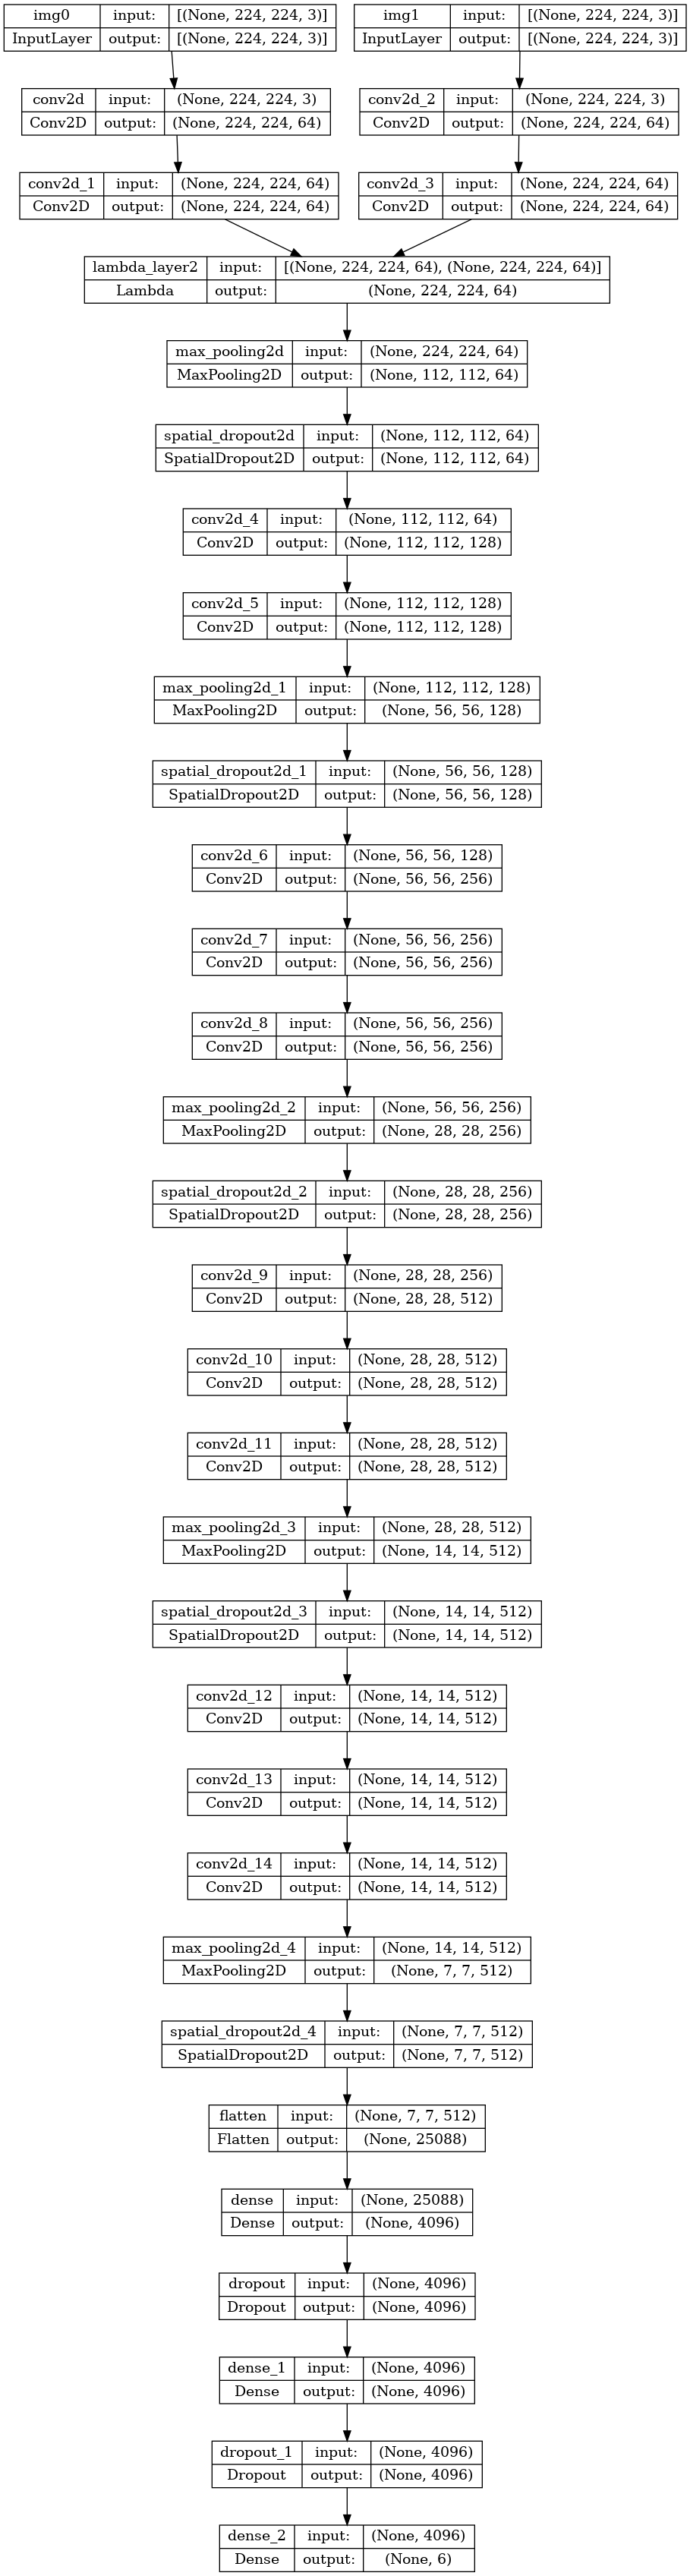

In [26]:
keras.utils.plot_model(model, "my_model_with_shape_info.png", show_shapes=True)

In [27]:
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)

In [28]:
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
maxAcc = np.max(fitHistory.history['val_accuracy'])

Start fitting from 2022/09/17-00:53:13

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40


2022-09-17 00:53:26.225461: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8401
2022-09-17 00:53:28.679516: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1793/1793 [==============================] - 160s 80ms/step - loss: 1.8127 - accuracy: 0.2348 - val_loss: 1.3570 - val_accuracy: 0.4309 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
1793/1793 [==============================] - 142s 79ms/step - loss: 1.3090 - accuracy: 0.4442 - val_loss: 1.0428 - val_accuracy: 0.5575 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
1793/1793 [==============================] - 143s 80ms/step - loss: 1.0237 - accuracy: 0.5850 - val_loss: 0.8147 - val_accuracy: 0.6654 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
1793/1793 [==============================] - 142s 79ms/step - loss: 0.8460 - accuracy: 0.6557 - val_loss: 0.6294 - val_accuracy: 0.7572 - lr: 2.0000e-05

Epoch 5: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 5/40
1793/1793 [=========

Maximum test accuracy is at 97.08 %.


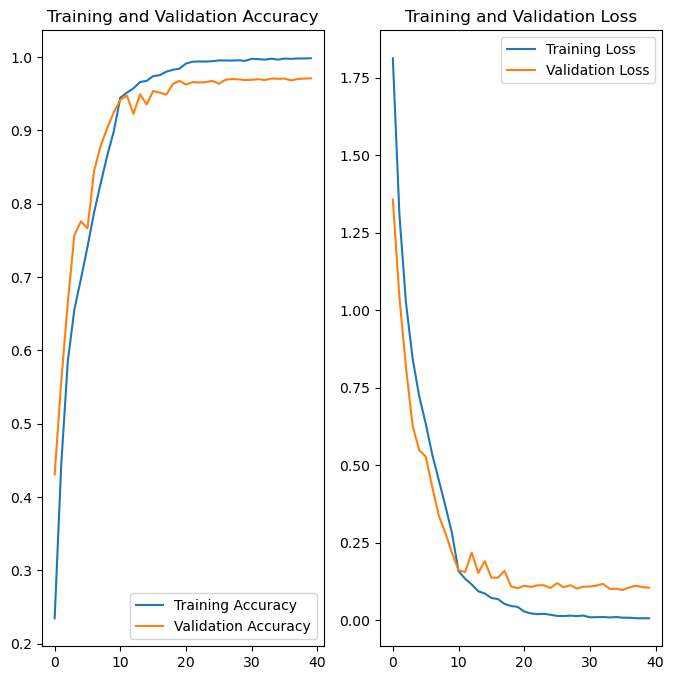

In [29]:
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)

In [30]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)

442/442 [==============================] - 11s 24ms/step
Confusion Matrix
[[583   2   0   0   1   1]
 [  1 549  12   0  16   6]
 [  1  22 560   0   4   2]
 [  0   0   1 590   0   1]
 [  0  31   0   0 562   0]
 [  0   1   1   0   0 583]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.99      0.99       587
           Aedes vexans       0.91      0.94      0.92       584
     Anopheles sinensis       0.98      0.95      0.96       589
          Culex pipiens       1.00      1.00      1.00       592
Culex tritaeniorhynchus       0.96      0.95      0.96       593
            Non vectors       0.98      1.00      0.99       585

               accuracy                           0.97      3530
              macro avg       0.97      0.97      0.97      3530
           weighted avg       0.97      0.97      0.97      3530

Model is saved in ./models/Model_Early_Combine_Park_2022-09-17_02-26.h5


In [31]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)

Start fitting from 2022/09/17-02:26:19

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
1793/1793 [==============================] - 162s 89ms/step - loss: 1.8552 - accuracy: 0.1590 - val_loss: 1.7896 - val_accuracy: 0.1680 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
1793/1793 [==============================] - 161s 90ms/step - loss: 1.7711 - accuracy: 0.1977 - val_loss: 1.4533 - val_accuracy: 0.3873 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
1793/1793 [==============================] - 160s 89ms/step - loss: 1.3558 - accuracy: 0.4082 - val_loss: 1.2151 - val_accuracy: 0.4620 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
1793/1793 [==============================] - 159s 89ms/step - loss: 1.2312 - accuracy: 0.4649 - val_loss: 1.1309 - val_accuracy: 0.467

Epoch 34/40
1793/1793 [==============================] - 160s 89ms/step - loss: 0.0063 - accuracy: 0.9978 - val_loss: 0.1010 - val_accuracy: 0.9751 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
1793/1793 [==============================] - 160s 90ms/step - loss: 0.0052 - accuracy: 0.9984 - val_loss: 0.1116 - val_accuracy: 0.9756 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
1793/1793 [==============================] - 160s 89ms/step - loss: 0.0057 - accuracy: 0.9980 - val_loss: 0.1128 - val_accuracy: 0.9742 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
1793/1793 [==============================] - 160s 89ms/step - loss: 0.0052 - accuracy: 0.9981 - val_loss: 0.1070 - val_accuracy: 0.9762 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
1793

Maximum test accuracy is at 97.73 %.


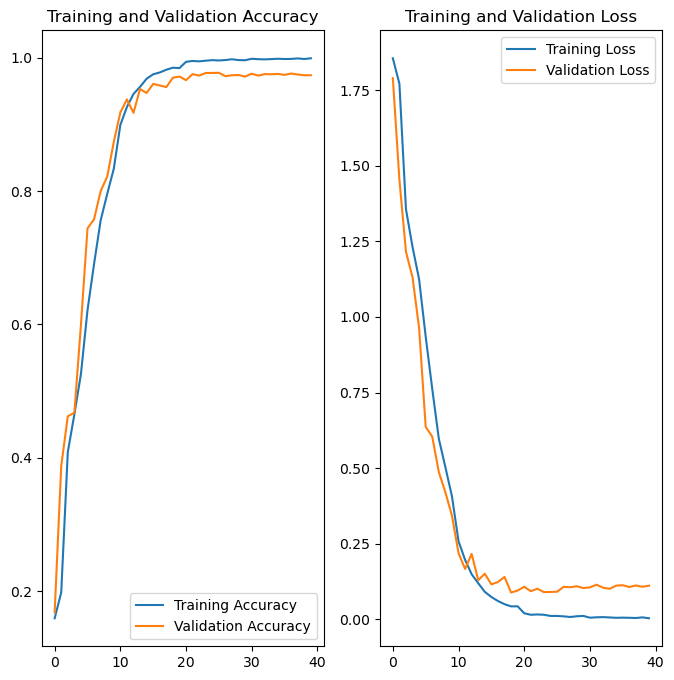

In [32]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)

In [33]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)

442/442 [==============================] - 11s 25ms/step
Confusion Matrix
[[585   1   1   0   0   0]
 [  0 553   5   1  23   2]
 [  0  19 565   1   3   1]
 [  0   1   0 591   0   0]
 [  1  28   0   0 564   0]
 [  0   1   1   4   0 579]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      1.00      1.00       587
           Aedes vexans       0.92      0.95      0.93       584
     Anopheles sinensis       0.99      0.96      0.97       589
          Culex pipiens       0.99      1.00      0.99       592
Culex tritaeniorhynchus       0.96      0.95      0.95       593
            Non vectors       0.99      0.99      0.99       585

               accuracy                           0.97      3530
              macro avg       0.97      0.97      0.97      3530
           weighted avg       0.97      0.97      0.97      3530

Model is saved in ./models/Model_Middle_Combine_Park_2022-09-17_04-13.h5


In [34]:
model = buildLateModel()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)

Start fitting from 2022/09/17-04:13:13

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
1793/1793 [==============================] - 185s 102ms/step - loss: 1.6000 - accuracy: 0.3044 - val_loss: 1.0873 - val_accuracy: 0.5558 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
1793/1793 [==============================] - 183s 102ms/step - loss: 0.9211 - accuracy: 0.6261 - val_loss: 0.8223 - val_accuracy: 0.6530 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
1793/1793 [==============================] - 184s 102ms/step - loss: 0.4666 - accuracy: 0.8211 - val_loss: 0.2336 - val_accuracy: 0.9193 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
1793/1793 [==============================] - 183s 102ms/step - loss: 0.2209 - accuracy: 0.9213 - val_loss: 0.1926 - val_accuracy: 0

Maximum test accuracy is at 98.61 %.


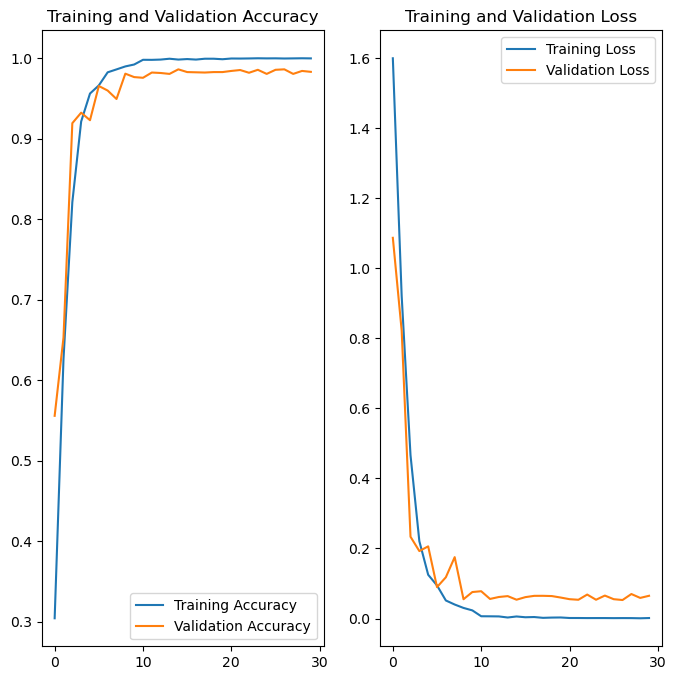

In [35]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)

In [36]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)

442/442 [==============================] - 12s 27ms/step
Confusion Matrix
[[583   2   0   0   0   2]
 [  0 572   0   0   8   4]
 [  0   6 579   0   2   2]
 [  0   1   0 590   0   1]
 [  0  12   0   0 581   0]
 [  0   1   2   6   0 576]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.99      1.00       587
           Aedes vexans       0.96      0.98      0.97       584
     Anopheles sinensis       1.00      0.98      0.99       589
          Culex pipiens       0.99      1.00      0.99       592
Culex tritaeniorhynchus       0.98      0.98      0.98       593
            Non vectors       0.98      0.98      0.98       585

               accuracy                           0.99      3530
              macro avg       0.99      0.99      0.99      3530
           weighted avg       0.99      0.99      0.99      3530

Model is saved in ./models/Model_Late_Combine_Park_2022-09-17_05-44.h5


In [37]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)

Found 9556 files belonging to 6 classes.
Found 2352 files belonging to 6 classes.
Found 9556 files belonging to 6 classes.
Found 2352 files belonging to 6 classes.
Found 9556 files belonging to 6 classes.
Found 2352 files belonging to 6 classes.


In [38]:
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)

In [39]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

294/294 [==============================] - 6s 22ms/step


In [40]:
model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)


294/294 [==============================] - 7s 25ms/step


In [41]:
model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

294/294 [==============================] - 8s 27ms/step


In [42]:
Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))

In [43]:
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)

In [44]:
ensemble = trainEnsemble(Yh_train, Y_train)

Epoch 1/20
598/598 [==============================] - 3s 4ms/step - loss: 0.6064 - accuracy: 0.8849
Epoch 2/20
598/598 [==============================] - 3s 4ms/step - loss: 0.0552 - accuracy: 0.9992
Epoch 3/20
598/598 [==============================] - 3s 4ms/step - loss: 0.0038 - accuracy: 0.9997
Epoch 4/20
598/598 [==============================] - 2s 4ms/step - loss: 0.0018 - accuracy: 0.9997
Epoch 5/20
598/598 [==============================] - 3s 4ms/step - loss: 0.0012 - accuracy: 0.9997
Epoch 6/20
598/598 [==============================] - 2s 4ms/step - loss: 8.1585e-04 - accuracy: 0.9998
Epoch 7/20
598/598 [==============================] - 3s 4ms/step - loss: 5.8383e-04 - accuracy: 0.9998
Epoch 8/20
598/598 [==============================] - 3s 4ms/step - loss: 4.3592e-04 - accuracy: 0.9998
Epoch 9/20
598/598 [==============================] - 3s 4ms/step - loss: 3.3503e-04 - accuracy: 0.9999
Epoch 10/20
598/598 [==============================] - 2s 4ms/step - loss: 2.2751e-0

In [45]:
ensemble.evaluate(Yh_val,Y_val)

74/74 [==============================] - 0s 2ms/step - loss: 0.0083 - accuracy: 0.9970


[0.008260048925876617, 0.9970238208770752]

74/74 [==============================] - 0s 1ms/step


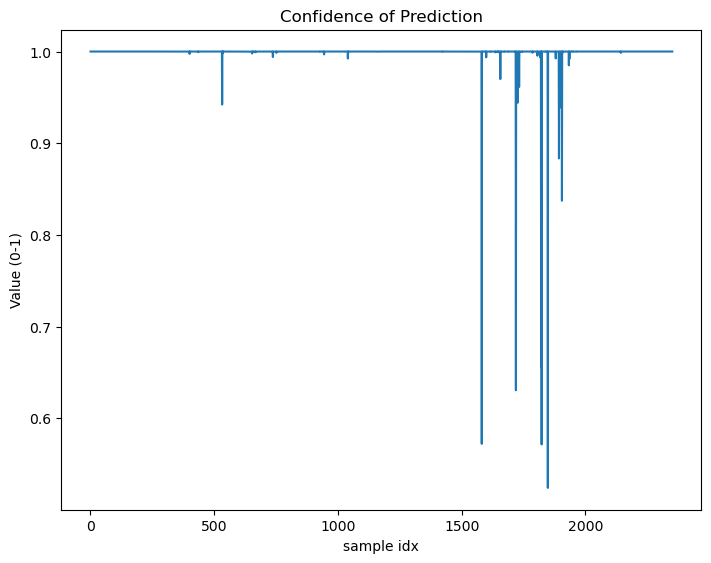

In [46]:
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)

In [47]:
#---------------MODEL2-----------------------------------------#

In [48]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp69gcsf3o/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp69gcsf3o/train/Aedes vexans/ = 4739.
No. of files in "/tmp/tmp69gcsf3o/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp69gcsf3o/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp69gcsf3o/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp69gcsf3o/val/Aedes vexans/ = 1162.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp69gcsf3o/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp69gcsf3o/train/Anopheles sinensis/ = 4746.
No. of files in "/tmp/tmp69gcsf3o/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp69gcsf3o/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp69gcsf3o/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp69gcsf3o/val/Anopheles sinensis/ = 1177.
Foun

((14348, 3519, 0), (9565, 2345, 0))

In [49]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 14348 files belonging to 6 classes.
Found 3519 files belonging to 6 classes.
Found 14348 files belonging to 6 classes.
Found 3519 files belonging to 6 classes.


In [50]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/17-05:57:37

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
1794/1794 [==============================] - 149s 77ms/step - loss: 1.6231 - accuracy: 0.3116 - val_loss: 1.2287 - val_accuracy: 0.4427 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
1794/1794 [==============================] - 133s 74ms/step - loss: 0.9978 - accuracy: 0.5967 - val_loss: 0.7935 - val_accuracy: 0.6684 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
1794/1794 [==============================] - 131s 73ms/step - loss: 0.6108 - accuracy: 0.7649 - val_loss: 0.4227 - val_accuracy: 0.8377 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
1794/1794 [==============================] - 130s 72ms/step - loss: 0.4034 - accuracy: 0.8492 - val_loss: 0.3555 - val_accuracy: 0.865

Epoch 34/40
1794/1794 [==============================] - 126s 70ms/step - loss: 0.0027 - accuracy: 0.9990 - val_loss: 0.0988 - val_accuracy: 0.9758 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
1794/1794 [==============================] - 126s 70ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.0995 - val_accuracy: 0.9773 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
1794/1794 [==============================] - 125s 70ms/step - loss: 0.0029 - accuracy: 0.9988 - val_loss: 0.0885 - val_accuracy: 0.9778 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
1794/1794 [==============================] - 126s 70ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.0942 - val_accuracy: 0.9773 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
1794

Maximum test accuracy is at 98.1 %.


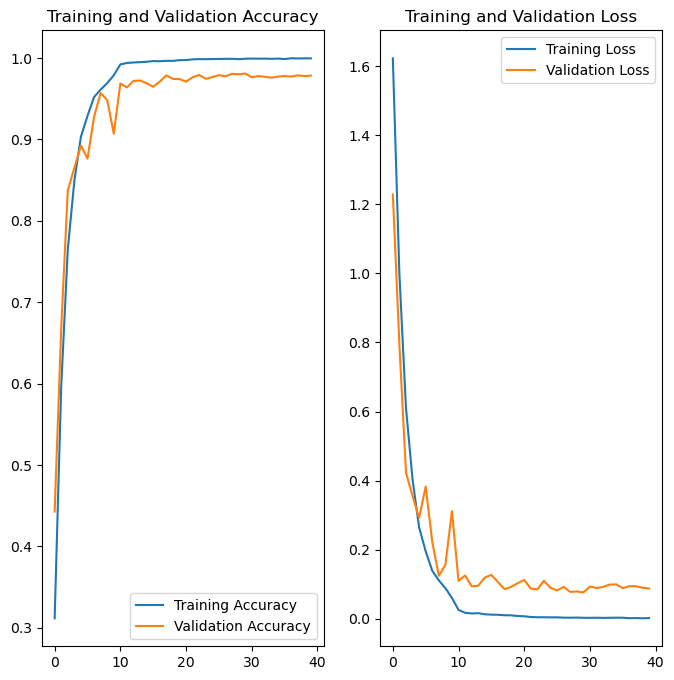

In [51]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [52]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

440/440 [==============================] - 10s 21ms/step
Confusion Matrix
[[593   0   1   0   0   0]
 [  0 565   3   0  10   3]
 [  0  23 561   1   3   0]
 [  2   0   0 582   0   0]
 [  0  16   0   0 573   0]
 [  0   1   0  13   0 569]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      1.00      1.00       594
           Aedes vexans       0.93      0.97      0.95       581
     Anopheles sinensis       0.99      0.95      0.97       588
          Culex pipiens       0.98      1.00      0.99       584
Culex tritaeniorhynchus       0.98      0.97      0.98       589
            Non vectors       0.99      0.98      0.99       583

               accuracy                           0.98      3519
              macro avg       0.98      0.98      0.98      3519
           weighted avg       0.98      0.98      0.98      3519

Model is saved in ./models/Model_Early_Combine_Park_2022-09-17_07-22.h5


In [53]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_76 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

                                                                                                  
 max_pooling2d_31 (MaxPooling2D  (None, 14, 14, 512)  0          ['conv2d_92[0][0]']              
 )                                                                                                
                                                                                                  
 spatial_dropout2d_30 (SpatialD  (None, 14, 14, 512)  0          ['max_pooling2d_31[0][0]']       
 ropout2D)                                                                                        
                                                                                                  
 conv2d_93 (Conv2D)             (None, 14, 14, 512)  2359808     ['spatial_dropout2d_30[0][0]']   
                                                                                                  
 conv2d_94 (Conv2D)             (None, 14, 14, 512)  2359808     ['conv2d_93[0][0]']              
          

Maximum test accuracy is at 97.16 %.


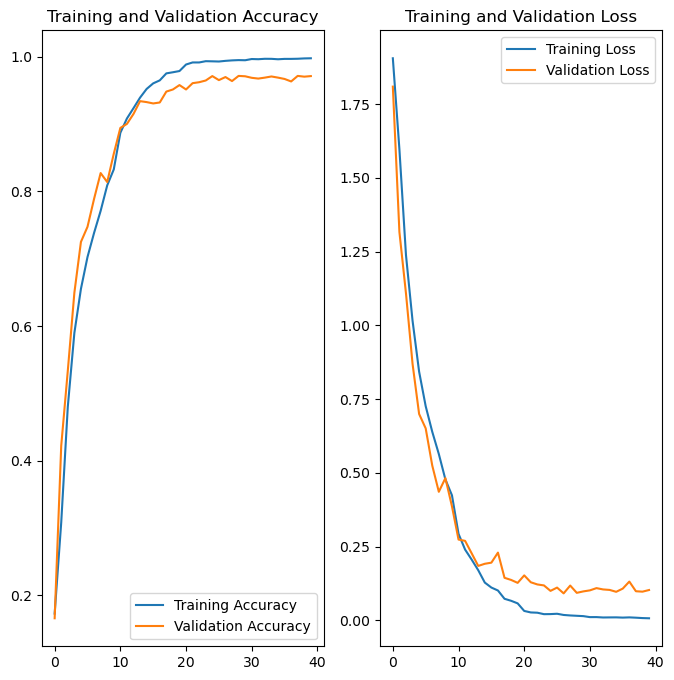

In [54]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [55]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

440/440 [==============================] - 11s 24ms/step
Confusion Matrix
[[590   1   1   0   1   1]
 [  2 561   2   0   8   8]
 [  1  31 547   1   2   6]
 [  0   4   1 579   0   0]
 [  0  27   0   0 562   0]
 [  0   1   1   2   0 579]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.99      0.99       594
           Aedes vexans       0.90      0.97      0.93       581
     Anopheles sinensis       0.99      0.93      0.96       588
          Culex pipiens       0.99      0.99      0.99       584
Culex tritaeniorhynchus       0.98      0.95      0.97       589
            Non vectors       0.97      0.99      0.98       583

               accuracy                           0.97      3519
              macro avg       0.97      0.97      0.97      3519
           weighted avg       0.97      0.97      0.97      3519

Model is saved in ./models/Model_Middle_Combine_Park_2022-09-17_09-02.h5


In [56]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

 conv2d_116 (Conv2D)            (None, 28, 28, 512)  1180160     ['spatial_dropout2d_38[0][0]']   
                                                                                                  
 conv2d_104 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_103[0][0]']             
                                                                                                  
 conv2d_117 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_116[0][0]']             
                                                                                                  
 conv2d_105 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_104[0][0]']             
                                                                                                  
 conv2d_118 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_117[0][0]']             
                                                                                                  
 max_pooli

Epoch 12/40
1794/1794 [==============================] - 174s 97ms/step - loss: 0.0073 - accuracy: 0.9977 - val_loss: 0.0833 - val_accuracy: 0.9750 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
1794/1794 [==============================] - 172s 96ms/step - loss: 0.0077 - accuracy: 0.9974 - val_loss: 0.0822 - val_accuracy: 0.9730 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
1794/1794 [==============================] - 172s 96ms/step - loss: 0.0062 - accuracy: 0.9978 - val_loss: 0.0889 - val_accuracy: 0.9707 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
1794/1794 [==============================] - 172s 96ms/step - loss: 0.0084 - accuracy: 0.9971 - val_loss: 0.0741 - val_accuracy: 0.9750 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
1794

Maximum test accuracy is at 98.35 %.


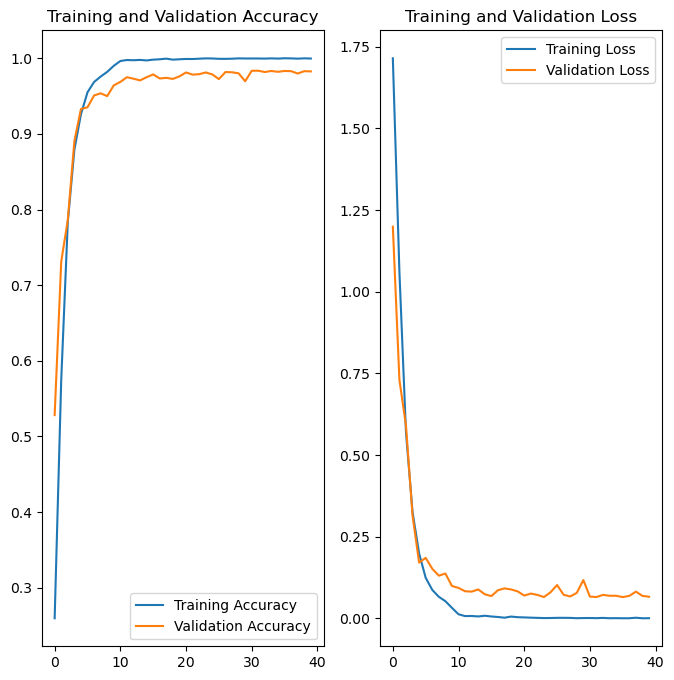

In [57]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [58]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

440/440 [==============================] - 12s 27ms/step
Confusion Matrix
[[589   4   0   0   0   1]
 [  0 571   1   0   5   4]
 [  0   5 578   0   0   5]
 [  0   0   0 584   0   0]
 [  0  11   0   0 578   0]
 [  0   5   2  18   0 558]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.99      1.00       594
           Aedes vexans       0.96      0.98      0.97       581
     Anopheles sinensis       0.99      0.98      0.99       588
          Culex pipiens       0.97      1.00      0.98       584
Culex tritaeniorhynchus       0.99      0.98      0.99       589
            Non vectors       0.98      0.96      0.97       583

               accuracy                           0.98      3519
              macro avg       0.98      0.98      0.98      3519
           weighted avg       0.98      0.98      0.98      3519

Model is saved in ./models/Model_Late_Combine_Park_2022-09-17_10-58.h5


In [59]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 9565 files belonging to 6 classes.
Found 2345 files belonging to 6 classes.
Found 9565 files belonging to 6 classes.
Found 2345 files belonging to 6 classes.
Found 9565 files belonging to 6 classes.
Found 2345 files belonging to 6 classes.


In [60]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

294/294 [==============================] - 8s 28ms/step


In [61]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
598/598 [==============================] - 2s 3ms/step - loss: 0.3882 - accuracy: 0.9237
Epoch 2/20
598/598 [==============================] - 3s 4ms/step - loss: 0.0140 - accuracy: 0.9998
Epoch 3/20
598/598 [==============================] - 3s 4ms/step - loss: 0.0046 - accuracy: 0.9997
Epoch 4/20
598/598 [==============================] - 3s 4ms/step - loss: 0.0023 - accuracy: 0.9998
Epoch 5/20
598/598 [==============================] - 2s 3ms/step - loss: 0.0014 - accuracy: 0.9998
Epoch 6/20
598/598 [==============================] - 2s 3ms/step - loss: 9.5474e-04 - accuracy: 0.9999
Epoch 7/20
598/598 [==============================] - 2s 4ms/step - loss: 6.7175e-04 - accuracy: 0.9999
Epoch 8/20
598/598 [==============================] - 2s 4ms/step - loss: 4.8558e-04 - accuracy: 0.9999
Epoch 9/20
598/598 [==============================] - 2s 4ms/step - loss: 3.4513e-04 - accuracy: 1.0000
Epoch 10/20
598/598 [==============================] - 2s 4ms/step - loss: 2.7070e-0

74/74 [==============================] - 0s 1ms/step


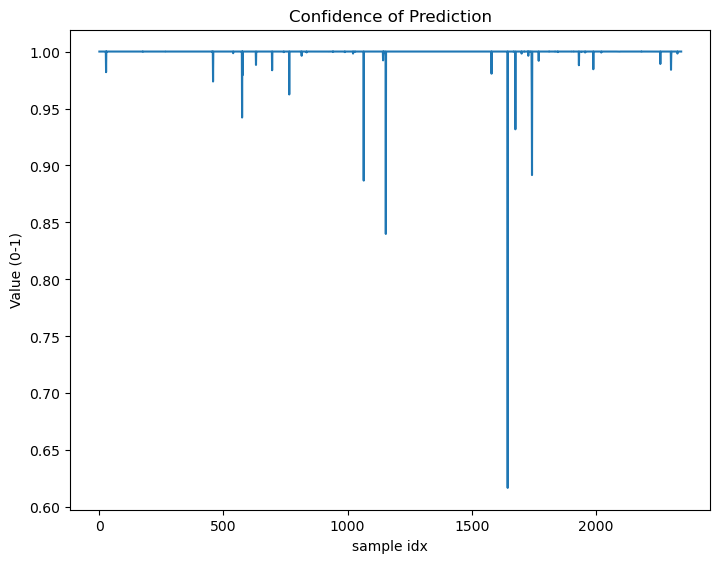

In [62]:
ensemble.evaluate(Yh_val,Y_val)
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)

In [63]:
#---------------MODEL3-----------------------------------------#

In [64]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----



Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp3pi680se/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp3pi680se/train/Aedes vexans/ = 4723.
No. of files in "/tmp/tmp3pi680se/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp3pi680se/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp3pi680se/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp3pi680se/val/Aedes vexans/ = 1178.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp3pi680se/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp3pi680se/train/Anopheles sinensis/ = 4745.
No. of files in "/tmp/tmp3pi680se/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp3pi680se/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp3pi680se/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp3pi680se/val/Anopheles sinensis/ = 1178.
Foun

((14320, 3548, 0), (9545, 2363, 0))

In [65]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 14320 files belonging to 6 classes.
Found 3548 files belonging to 6 classes.
Found 14320 files belonging to 6 classes.
Found 3548 files belonging to 6 classes.


In [66]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/17-11:11:56

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
1790/1790 [==============================] - 147s 75ms/step - loss: 1.9027 - accuracy: 0.1621 - val_loss: 1.8063 - val_accuracy: 0.1522 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
1790/1790 [==============================] - 125s 70ms/step - loss: 1.7502 - accuracy: 0.2215 - val_loss: 1.6676 - val_accuracy: 0.2148 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
1790/1790 [==============================] - 124s 69ms/step - loss: 1.2319 - accuracy: 0.4778 - val_loss: 0.9917 - val_accuracy: 0.5800 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
1790/1790 [==============================] - 130s 73ms/step - loss: 0.9027 - accuracy: 0.6299 - val_loss: 0.7752 - val_accuracy: 0.709

Epoch 34/40
1790/1790 [==============================] - 129s 72ms/step - loss: 0.0026 - accuracy: 0.9991 - val_loss: 0.0984 - val_accuracy: 0.9724 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
1790/1790 [==============================] - 131s 73ms/step - loss: 0.0028 - accuracy: 0.9989 - val_loss: 0.0884 - val_accuracy: 0.9746 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
1790/1790 [==============================] - 132s 74ms/step - loss: 0.0026 - accuracy: 0.9992 - val_loss: 0.0874 - val_accuracy: 0.9746 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
1790/1790 [==============================] - 126s 71ms/step - loss: 0.0017 - accuracy: 0.9996 - val_loss: 0.0900 - val_accuracy: 0.9749 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
1790

Maximum test accuracy is at 97.58 %.


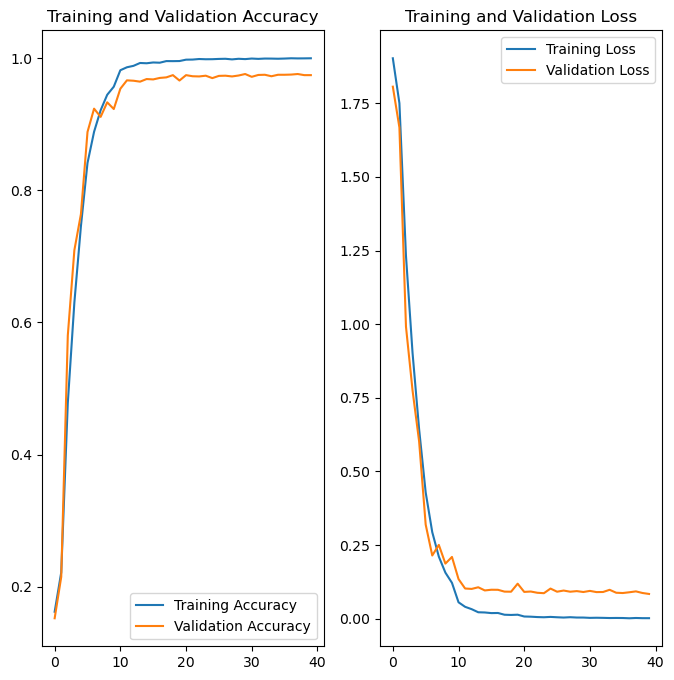

In [67]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [68]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

444/444 [==============================] - 10s 21ms/step
Confusion Matrix
[[587   1   0   0   0   2]
 [  0 553  11   0  21   4]
 [  0  17 566   0   4   2]
 [  0   0   0 586   0   1]
 [  0  23   0   0 571   0]
 [  0   2   1   3   0 593]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.99      1.00       590
           Aedes vexans       0.93      0.94      0.93       589
     Anopheles sinensis       0.98      0.96      0.97       589
          Culex pipiens       0.99      1.00      1.00       587
Culex tritaeniorhynchus       0.96      0.96      0.96       594
            Non vectors       0.99      0.99      0.99       599

               accuracy                           0.97      3548
              macro avg       0.97      0.97      0.97      3548
           weighted avg       0.97      0.97      0.97      3548

Model is saved in ./models/Model_Early_Combine_Park_2022-09-17_12-39.h5


In [69]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_137 (Conv2D)            (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

                                                                                                  
 max_pooling2d_52 (MaxPooling2D  (None, 14, 14, 512)  0          ['conv2d_153[0][0]']             
 )                                                                                                
                                                                                                  
 spatial_dropout2d_50 (SpatialD  (None, 14, 14, 512)  0          ['max_pooling2d_52[0][0]']       
 ropout2D)                                                                                        
                                                                                                  
 conv2d_154 (Conv2D)            (None, 14, 14, 512)  2359808     ['spatial_dropout2d_50[0][0]']   
                                                                                                  
 conv2d_155 (Conv2D)            (None, 14, 14, 512)  2359808     ['conv2d_154[0][0]']             
          

Maximum test accuracy is at 97.41 %.


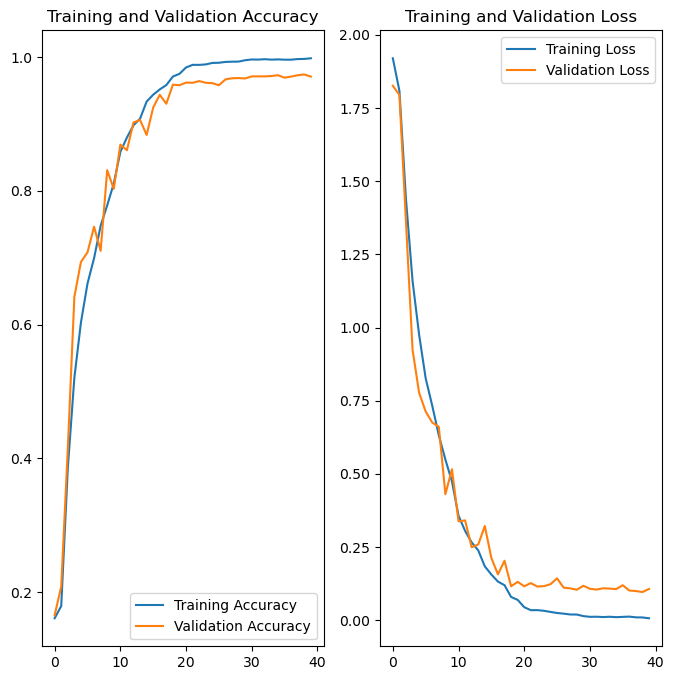

In [70]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [71]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

444/444 [==============================] - 11s 24ms/step
Confusion Matrix
[[587   2   0   0   0   1]
 [  0 552   3   4  26   4]
 [  0  12 569   3   4   1]
 [  0   1   0 586   0   0]
 [  0  32   0   0 562   0]
 [  0   2   1   7   0 589]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.99      1.00       590
           Aedes vexans       0.92      0.94      0.93       589
     Anopheles sinensis       0.99      0.97      0.98       589
          Culex pipiens       0.98      1.00      0.99       587
Culex tritaeniorhynchus       0.95      0.95      0.95       594
            Non vectors       0.99      0.98      0.99       599

               accuracy                           0.97      3548
              macro avg       0.97      0.97      0.97      3548
           weighted avg       0.97      0.97      0.97      3548

Model is saved in ./models/Model_Middle_Combine_Park_2022-09-17_14-23.h5


In [72]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_157 (Conv2D)            (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                           

 conv2d_177 (Conv2D)            (None, 28, 28, 512)  1180160     ['spatial_dropout2d_58[0][0]']   
                                                                                                  
 conv2d_165 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_164[0][0]']             
                                                                                                  
 conv2d_178 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_177[0][0]']             
                                                                                                  
 conv2d_166 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_165[0][0]']             
                                                                                                  
 conv2d_179 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_178[0][0]']             
                                                                                                  
 max_pooli

Epoch 12/40
1790/1790 [==============================] - 178s 99ms/step - loss: 0.0048 - accuracy: 0.9989 - val_loss: 0.0618 - val_accuracy: 0.9783 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
1790/1790 [==============================] - 176s 99ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.0562 - val_accuracy: 0.9820 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
1790/1790 [==============================] - 178s 99ms/step - loss: 0.0037 - accuracy: 0.9990 - val_loss: 0.0623 - val_accuracy: 0.9814 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
1790/1790 [==============================] - 177s 99ms/step - loss: 0.0050 - accuracy: 0.9983 - val_loss: 0.0522 - val_accuracy: 0.9834 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
1790

Maximum test accuracy is at 98.82 %.


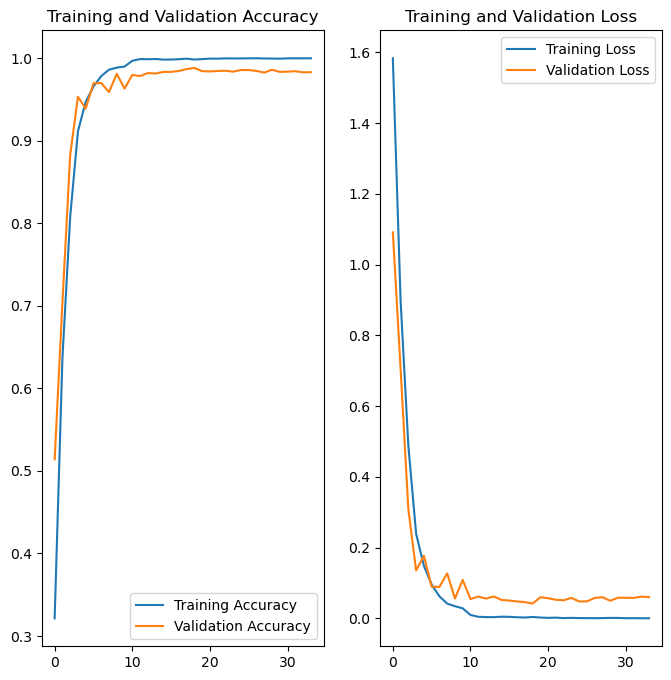

In [73]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [74]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

444/444 [==============================] - 13s 27ms/step
Confusion Matrix
[[590   0   0   0   0   0]
 [  0 574   0   0  14   1]
 [  0   0 587   0   0   2]
 [  0   0   0 584   0   3]
 [  0  13   0   0 581   0]
 [  0   7   0   2   0 590]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      1.00      1.00       590
           Aedes vexans       0.97      0.97      0.97       589
     Anopheles sinensis       1.00      1.00      1.00       589
          Culex pipiens       1.00      0.99      1.00       587
Culex tritaeniorhynchus       0.98      0.98      0.98       594
            Non vectors       0.99      0.98      0.99       599

               accuracy                           0.99      3548
              macro avg       0.99      0.99      0.99      3548
           weighted avg       0.99      0.99      0.99      3548

Model is saved in ./models/Model_Late_Combine_Park_2022-09-17_16-04.h5


In [75]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 9545 files belonging to 6 classes.
Found 2363 files belonging to 6 classes.
Found 9545 files belonging to 6 classes.
Found 2363 files belonging to 6 classes.
Found 9545 files belonging to 6 classes.
Found 2363 files belonging to 6 classes.


In [76]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

296/296 [==============================] - 8s 27ms/step


In [77]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
597/597 [==============================] - 2s 3ms/step - loss: 0.3616 - accuracy: 0.8919
Epoch 2/20
597/597 [==============================] - 3s 5ms/step - loss: 0.0098 - accuracy: 0.9998
Epoch 3/20
597/597 [==============================] - 3s 4ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 4/20
597/597 [==============================] - 2s 3ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 5/20
597/597 [==============================] - 2s 4ms/step - loss: 9.7265e-04 - accuracy: 1.0000
Epoch 6/20
597/597 [==============================] - 2s 4ms/step - loss: 6.1796e-04 - accuracy: 1.0000
Epoch 7/20
597/597 [==============================] - 3s 5ms/step - loss: 4.0833e-04 - accuracy: 1.0000
Epoch 8/20
597/597 [==============================] - 2s 4ms/step - loss: 2.8540e-04 - accuracy: 1.0000
Epoch 9/20
597/597 [==============================] - 3s 4ms/step - loss: 2.0031e-04 - accuracy: 1.0000
Epoch 10/20
597/597 [==============================] - 2s 4ms/step - loss: 1.449

74/74 [==============================] - 0s 1ms/step


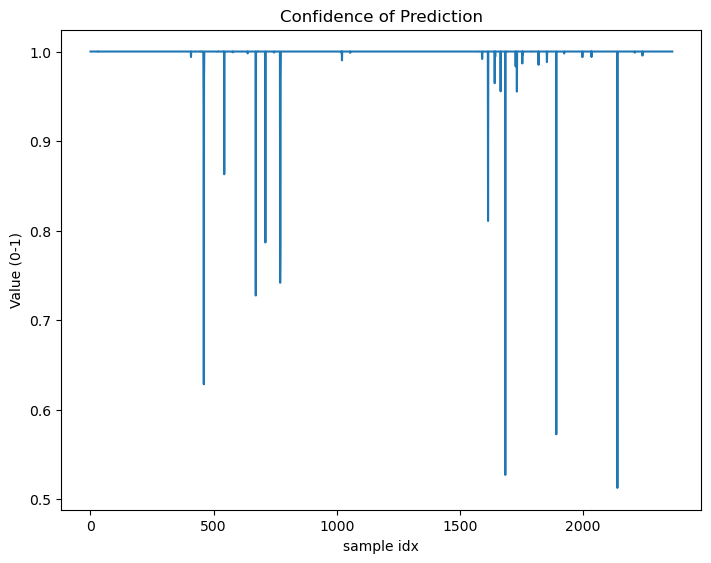

In [78]:
ensemble.evaluate(Yh_val,Y_val)
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)

In [79]:
#---------------MODEL4-----------------------------------------#

In [80]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp87cwqos2/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp87cwqos2/train/Aedes vexans/ = 4735.
No. of files in "/tmp/tmp87cwqos2/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp87cwqos2/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp87cwqos2/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp87cwqos2/val/Aedes vexans/ = 1166.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp87cwqos2/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp87cwqos2/train/Anopheles sinensis/ = 4739.
No. of files in "/tmp/tmp87cwqos2/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp87cwqos2/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp87cwqos2/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp87cwqos2/val/Anopheles sinensis/ = 1184.
Foun

((14327, 3542, 0), (9550, 2359, 0))

In [81]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 14327 files belonging to 6 classes.
Found 3542 files belonging to 6 classes.
Found 14327 files belonging to 6 classes.
Found 3542 files belonging to 6 classes.


In [82]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/17-16:17:15

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
1791/1791 [==============================] - 138s 72ms/step - loss: 1.7009 - accuracy: 0.2666 - val_loss: 1.2834 - val_accuracy: 0.4393 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
1791/1791 [==============================] - 131s 73ms/step - loss: 1.1966 - accuracy: 0.4834 - val_loss: 0.8615 - val_accuracy: 0.6448 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
1791/1791 [==============================] - 127s 71ms/step - loss: 0.8345 - accuracy: 0.6713 - val_loss: 0.5390 - val_accuracy: 0.8199 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
1791/1791 [==============================] - 128s 71ms/step - loss: 0.5583 - accuracy: 0.7868 - val_loss: 0.3153 - val_accuracy: 0.895

Epoch 34/40
1791/1791 [==============================] - 125s 70ms/step - loss: 0.0032 - accuracy: 0.9988 - val_loss: 0.0418 - val_accuracy: 0.9864 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
1791/1791 [==============================] - 125s 70ms/step - loss: 0.0033 - accuracy: 0.9992 - val_loss: 0.0414 - val_accuracy: 0.9881 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
1791/1791 [==============================] - 124s 69ms/step - loss: 0.0023 - accuracy: 0.9993 - val_loss: 0.0426 - val_accuracy: 0.9881 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
1791/1791 [==============================] - 128s 71ms/step - loss: 0.0025 - accuracy: 0.9992 - val_loss: 0.0395 - val_accuracy: 0.9879 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
1791

Maximum test accuracy is at 98.84 %.


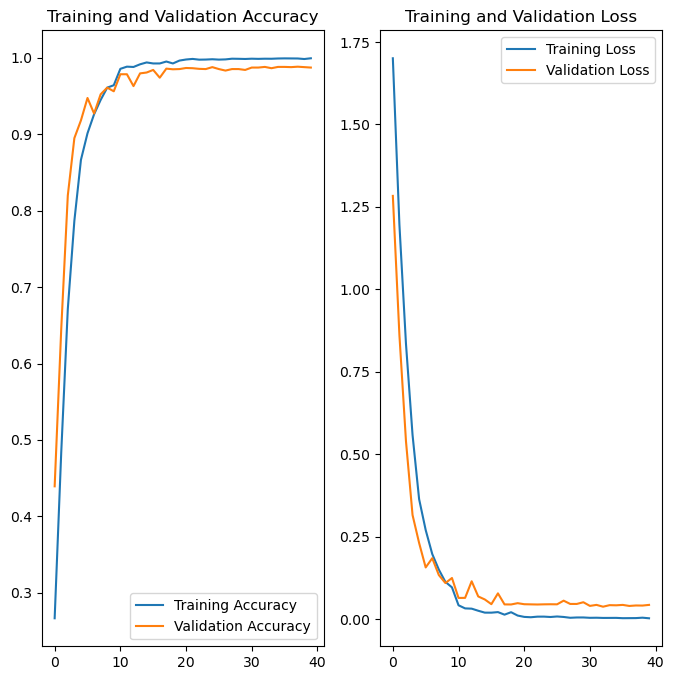

In [83]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [84]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

443/443 [==============================] - 10s 21ms/step
Confusion Matrix
[[592   0   0   0   1   1]
 [  0 574   1   0   6   2]
 [  0   7 584   0   0   1]
 [  0   1   1 593   0   0]
 [  0  14   0   0 570   0]
 [  1   5   0   4   0 584]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      1.00      1.00       594
           Aedes vexans       0.96      0.98      0.97       583
     Anopheles sinensis       1.00      0.99      0.99       592
          Culex pipiens       0.99      1.00      0.99       595
Culex tritaeniorhynchus       0.99      0.98      0.98       584
            Non vectors       0.99      0.98      0.99       594

               accuracy                           0.99      3542
              macro avg       0.99      0.99      0.99      3542
           weighted avg       0.99      0.99      0.99      3542

Model is saved in ./models/Model_Early_Combine_Park_2022-09-17_17-41.h5


In [85]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_198 (Conv2D)            (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                          

                                                                                                  
 max_pooling2d_73 (MaxPooling2D  (None, 14, 14, 512)  0          ['conv2d_214[0][0]']             
 )                                                                                                
                                                                                                  
 spatial_dropout2d_70 (SpatialD  (None, 14, 14, 512)  0          ['max_pooling2d_73[0][0]']       
 ropout2D)                                                                                        
                                                                                                  
 conv2d_215 (Conv2D)            (None, 14, 14, 512)  2359808     ['spatial_dropout2d_70[0][0]']   
                                                                                                  
 conv2d_216 (Conv2D)            (None, 14, 14, 512)  2359808     ['conv2d_215[0][0]']             
          

Maximum test accuracy is at 98.81 %.


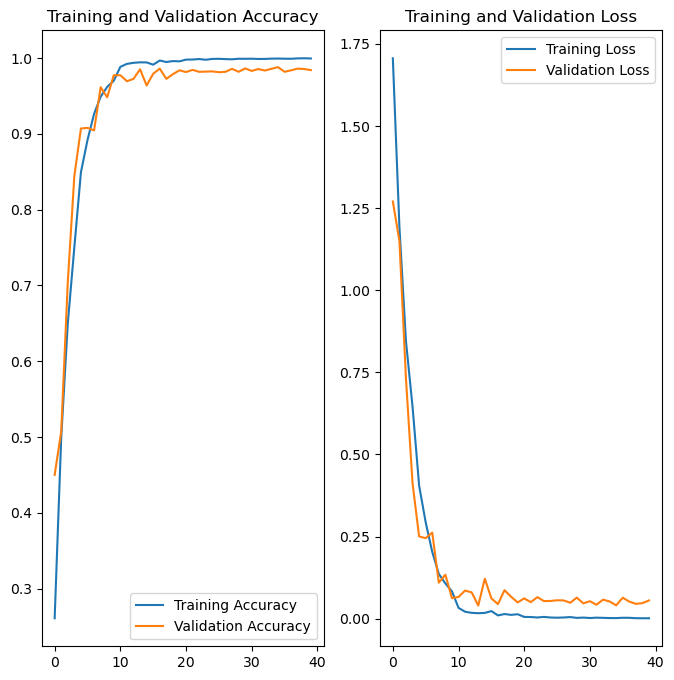

In [86]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [87]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

443/443 [==============================] - 11s 23ms/step
Confusion Matrix
[[591   1   0   0   0   2]
 [  0 577   0   0   5   1]
 [  0  12 580   0   0   0]
 [  0   0   0 595   0   0]
 [  0  13   0   0 571   0]
 [  1  15   2   4   0 572]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.99      1.00       594
           Aedes vexans       0.93      0.99      0.96       583
     Anopheles sinensis       1.00      0.98      0.99       592
          Culex pipiens       0.99      1.00      1.00       595
Culex tritaeniorhynchus       0.99      0.98      0.98       584
            Non vectors       0.99      0.96      0.98       594

               accuracy                           0.98      3542
              macro avg       0.98      0.98      0.98      3542
           weighted avg       0.98      0.98      0.98      3542

Model is saved in ./models/Model_Middle_Combine_Park_2022-09-17_19-21.h5


In [88]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_218 (Conv2D)            (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                          

 conv2d_238 (Conv2D)            (None, 28, 28, 512)  1180160     ['spatial_dropout2d_78[0][0]']   
                                                                                                  
 conv2d_226 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_225[0][0]']             
                                                                                                  
 conv2d_239 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_238[0][0]']             
                                                                                                  
 conv2d_227 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_226[0][0]']             
                                                                                                  
 conv2d_240 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_239[0][0]']             
                                                                                                  
 max_pooli

Epoch 12/40
1791/1791 [==============================] - 171s 95ms/step - loss: 0.0049 - accuracy: 0.9983 - val_loss: 0.0534 - val_accuracy: 0.9831 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
1791/1791 [==============================] - 172s 96ms/step - loss: 0.0069 - accuracy: 0.9978 - val_loss: 0.0350 - val_accuracy: 0.9907 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
1791/1791 [==============================] - 170s 95ms/step - loss: 0.0044 - accuracy: 0.9984 - val_loss: 0.0470 - val_accuracy: 0.9859 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
1791/1791 [==============================] - 174s 97ms/step - loss: 0.0029 - accuracy: 0.9992 - val_loss: 0.0472 - val_accuracy: 0.9879 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
1791

Maximum test accuracy is at 99.24 %.


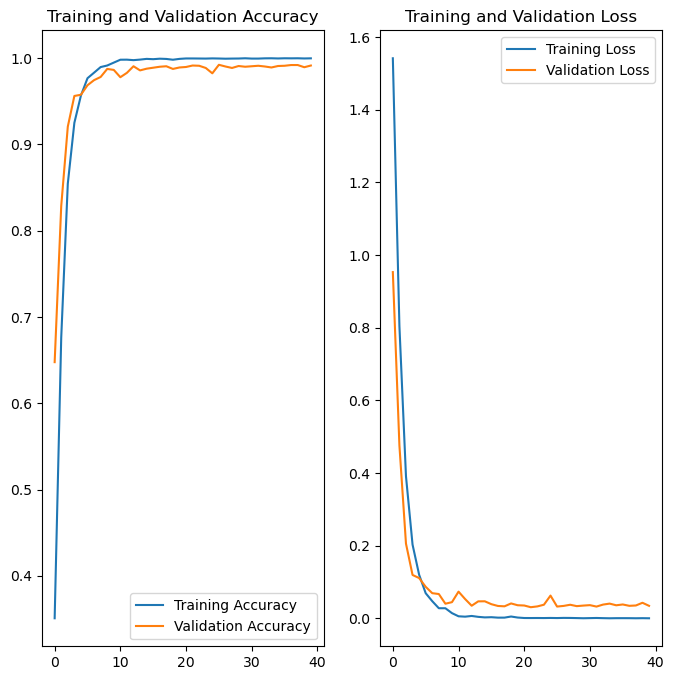

In [89]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [90]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

443/443 [==============================] - 13s 27ms/step
Confusion Matrix
[[594   0   0   0   0   0]
 [  0 579   0   0   3   1]
 [  0   2 589   0   0   1]
 [  0   0   0 595   0   0]
 [  0   3   0   0 581   0]
 [  0   8   5   7   0 574]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      1.00      1.00       594
           Aedes vexans       0.98      0.99      0.99       583
     Anopheles sinensis       0.99      0.99      0.99       592
          Culex pipiens       0.99      1.00      0.99       595
Culex tritaeniorhynchus       0.99      0.99      0.99       584
            Non vectors       1.00      0.97      0.98       594

               accuracy                           0.99      3542
              macro avg       0.99      0.99      0.99      3542
           weighted avg       0.99      0.99      0.99      3542

Model is saved in ./models/Model_Late_Combine_Park_2022-09-17_21-17.h5


In [91]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 9550 files belonging to 6 classes.
Found 2359 files belonging to 6 classes.
Found 9550 files belonging to 6 classes.
Found 2359 files belonging to 6 classes.
Found 9550 files belonging to 6 classes.
Found 2359 files belonging to 6 classes.


In [92]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

295/295 [==============================] - 9s 29ms/step


In [93]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
597/597 [==============================] - 3s 4ms/step - loss: 0.3470 - accuracy: 0.9024
Epoch 2/20
597/597 [==============================] - 3s 4ms/step - loss: 0.0099 - accuracy: 0.9999
Epoch 3/20
597/597 [==============================] - 3s 4ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 4/20
597/597 [==============================] - 3s 4ms/step - loss: 0.0016 - accuracy: 1.0000
Epoch 5/20
597/597 [==============================] - 3s 4ms/step - loss: 9.6953e-04 - accuracy: 1.0000
Epoch 6/20
597/597 [==============================] - 3s 4ms/step - loss: 6.1707e-04 - accuracy: 1.0000
Epoch 7/20
597/597 [==============================] - 3s 4ms/step - loss: 4.0622e-04 - accuracy: 1.0000
Epoch 8/20
597/597 [==============================] - 3s 4ms/step - loss: 2.8610e-04 - accuracy: 1.0000
Epoch 9/20
597/597 [==============================] - 3s 4ms/step - loss: 2.0483e-04 - accuracy: 1.0000
Epoch 10/20
597/597 [==============================] - 3s 4ms/step - loss: 1.378

74/74 [==============================] - 0s 1ms/step


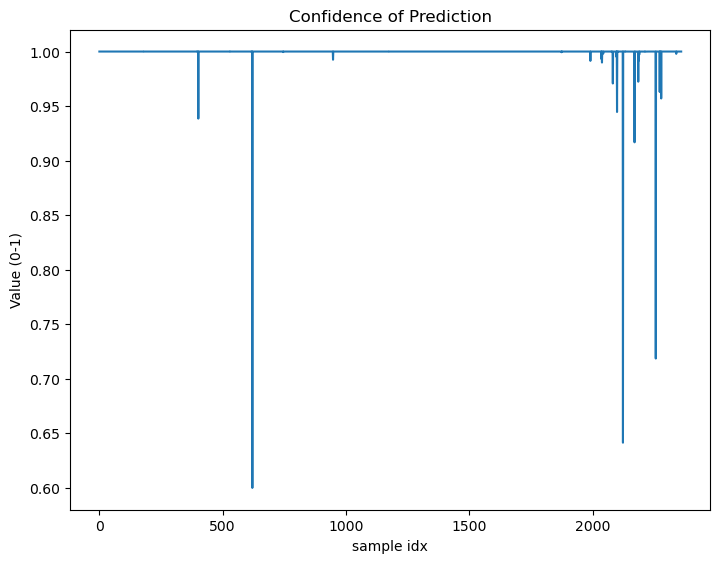

In [94]:
ensemble.evaluate(Yh_val,Y_val)
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)


In [95]:
#---------------MODEL 5-----------------------------------------#

In [96]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmprt1nao4p/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmprt1nao4p/train/Aedes vexans/ = 4724.
No. of files in "/tmp/tmprt1nao4p/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmprt1nao4p/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmprt1nao4p/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmprt1nao4p/val/Aedes vexans/ = 1177.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmprt1nao4p/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmprt1nao4p/train/Anopheles sinensis/ = 4764.
No. of files in "/tmp/tmprt1nao4p/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmprt1nao4p/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmprt1nao4p/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmprt1nao4p/val/Anopheles sinensis/ = 1159.
Foun

((14320, 3546, 0), (9545, 2364, 0))

In [97]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 14320 files belonging to 6 classes.
Found 3546 files belonging to 6 classes.
Found 14320 files belonging to 6 classes.
Found 3546 files belonging to 6 classes.


In [98]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/17-21:30:47

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
1790/1790 [==============================] - 140s 73ms/step - loss: 1.6641 - accuracy: 0.2879 - val_loss: 1.3007 - val_accuracy: 0.3818 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
1790/1790 [==============================] - 129s 72ms/step - loss: 1.0777 - accuracy: 0.5634 - val_loss: 0.6572 - val_accuracy: 0.7496 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
1790/1790 [==============================] - 124s 69ms/step - loss: 0.7044 - accuracy: 0.7263 - val_loss: 0.5643 - val_accuracy: 0.7719 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
1790/1790 [==============================] - 128s 72ms/step - loss: 0.4491 - accuracy: 0.8370 - val_loss: 0.5026 - val_accuracy: 0.799

Epoch 34/40
1790/1790 [==============================] - 128s 71ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0382 - val_accuracy: 0.9859 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
1790/1790 [==============================] - 132s 74ms/step - loss: 0.0031 - accuracy: 0.9989 - val_loss: 0.0402 - val_accuracy: 0.9865 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
1790/1790 [==============================] - 131s 73ms/step - loss: 0.0024 - accuracy: 0.9992 - val_loss: 0.0397 - val_accuracy: 0.9859 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
1790/1790 [==============================] - 136s 76ms/step - loss: 0.0019 - accuracy: 0.9994 - val_loss: 0.0412 - val_accuracy: 0.9859 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
1790

Maximum test accuracy is at 98.87 %.


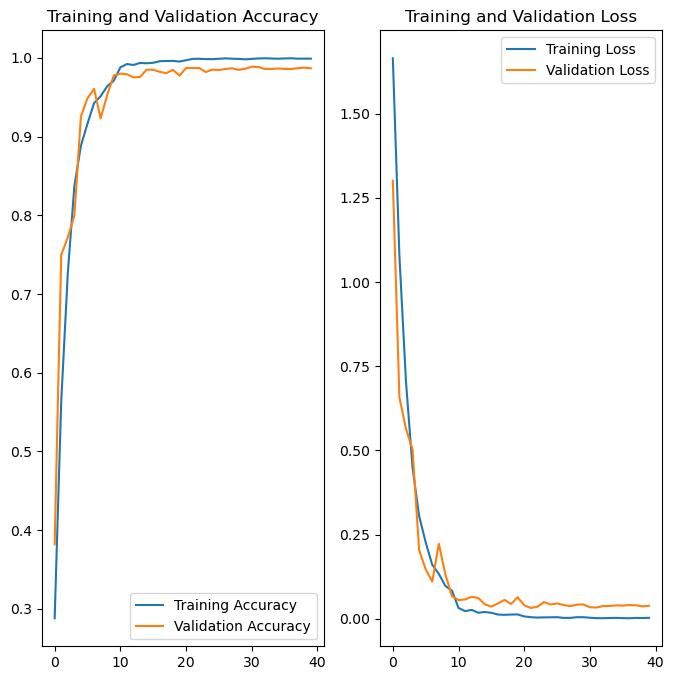

In [99]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [100]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

444/444 [==============================] - 10s 22ms/step
Confusion Matrix
[[599   0   0   0   1   0]
 [  0 570   2   1  12   3]
 [  0   5 572   1   0   1]
 [  0   0   0 594   0   0]
 [  0  12   0   0 573   0]
 [  0   2   2   5   0 591]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      1.00      1.00       600
           Aedes vexans       0.97      0.97      0.97       588
     Anopheles sinensis       0.99      0.99      0.99       579
          Culex pipiens       0.99      1.00      0.99       594
Culex tritaeniorhynchus       0.98      0.98      0.98       585
            Non vectors       0.99      0.98      0.99       600

               accuracy                           0.99      3546
              macro avg       0.99      0.99      0.99      3546
           weighted avg       0.99      0.99      0.99      3546

Model is saved in ./models/Model_Early_Combine_Park_2022-09-17_22-57.h5


In [101]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_259 (Conv2D)            (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                          

                                                                                                  
 max_pooling2d_94 (MaxPooling2D  (None, 14, 14, 512)  0          ['conv2d_275[0][0]']             
 )                                                                                                
                                                                                                  
 spatial_dropout2d_90 (SpatialD  (None, 14, 14, 512)  0          ['max_pooling2d_94[0][0]']       
 ropout2D)                                                                                        
                                                                                                  
 conv2d_276 (Conv2D)            (None, 14, 14, 512)  2359808     ['spatial_dropout2d_90[0][0]']   
                                                                                                  
 conv2d_277 (Conv2D)            (None, 14, 14, 512)  2359808     ['conv2d_276[0][0]']             
          

Maximum test accuracy is at 98.51 %.


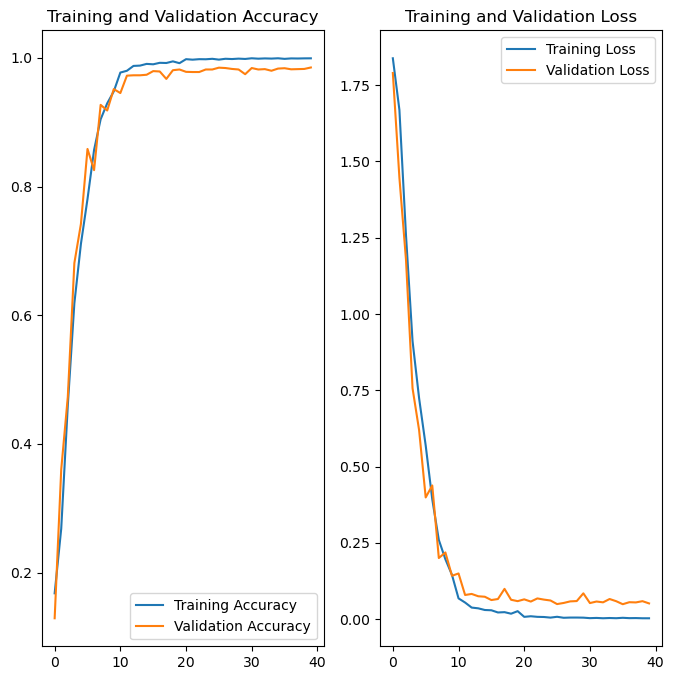

In [102]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [103]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

444/444 [==============================] - 11s 25ms/step
Confusion Matrix
[[595   4   0   1   0   0]
 [  1 570   1   0  12   4]
 [  0   2 575   1   0   1]
 [  0   1   0 593   0   0]
 [  0  14   0   0 571   0]
 [  2   3   0   6   0 589]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.99      0.99       600
           Aedes vexans       0.96      0.97      0.96       588
     Anopheles sinensis       1.00      0.99      1.00       579
          Culex pipiens       0.99      1.00      0.99       594
Culex tritaeniorhynchus       0.98      0.98      0.98       585
            Non vectors       0.99      0.98      0.99       600

               accuracy                           0.99      3546
              macro avg       0.99      0.99      0.99      3546
           weighted avg       0.99      0.99      0.99      3546

Model is saved in ./models/Model_Middle_Combine_Park_2022-09-18_00-39.h5


In [104]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_279 (Conv2D)            (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                          

 conv2d_299 (Conv2D)            (None, 28, 28, 512)  1180160     ['spatial_dropout2d_98[0][0]']   
                                                                                                  
 conv2d_287 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_286[0][0]']             
                                                                                                  
 conv2d_300 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_299[0][0]']             
                                                                                                  
 conv2d_288 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_287[0][0]']             
                                                                                                  
 conv2d_301 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_300[0][0]']             
                                                                                                  
 max_pooli

Epoch 12/40
1790/1790 [==============================] - 175s 98ms/step - loss: 0.0062 - accuracy: 0.9981 - val_loss: 0.0987 - val_accuracy: 0.9704 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
1790/1790 [==============================] - 176s 98ms/step - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.1096 - val_accuracy: 0.9659 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
1790/1790 [==============================] - 178s 100ms/step - loss: 0.0067 - accuracy: 0.9978 - val_loss: 0.0950 - val_accuracy: 0.9718 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
1790/1790 [==============================] - 169s 95ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.0970 - val_accuracy: 0.9729 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
179

Maximum test accuracy is at 97.66 %.


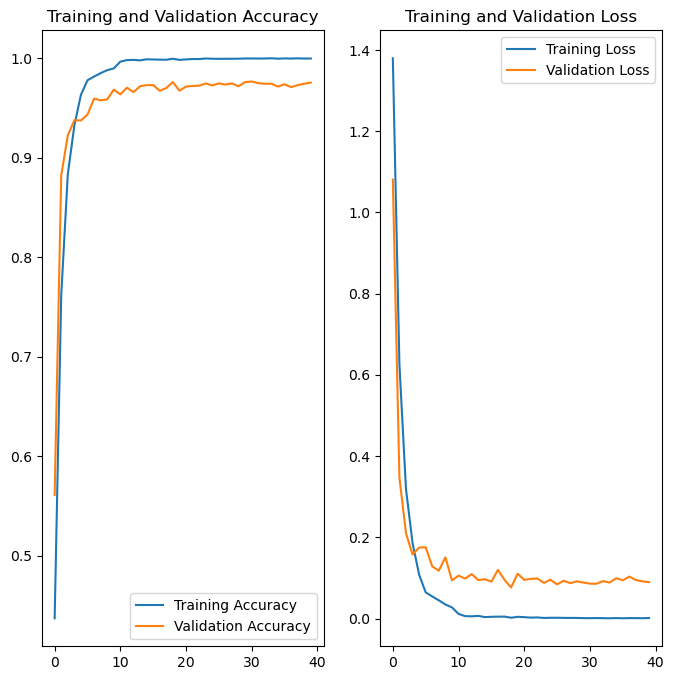

In [105]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [106]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

444/444 [==============================] - 12s 27ms/step
Confusion Matrix
[[596   2   0   1   0   1]
 [  1 555   2   1  23   6]
 [  0   0 578   0   0   1]
 [  0   1   0 593   0   0]
 [  3  12   0   0 570   0]
 [  4   5   3  21   0 567]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       0.99      0.99      0.99       600
           Aedes vexans       0.97      0.94      0.95       588
     Anopheles sinensis       0.99      1.00      0.99       579
          Culex pipiens       0.96      1.00      0.98       594
Culex tritaeniorhynchus       0.96      0.97      0.97       585
            Non vectors       0.99      0.94      0.97       600

               accuracy                           0.98      3546
              macro avg       0.98      0.98      0.98      3546
           weighted avg       0.98      0.98      0.98      3546

Model is saved in ./models/Model_Late_Combine_Park_2022-09-18_02-37.h5


In [107]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 9545 files belonging to 6 classes.
Found 2364 files belonging to 6 classes.
Found 9545 files belonging to 6 classes.
Found 2364 files belonging to 6 classes.
Found 9545 files belonging to 6 classes.
Found 2364 files belonging to 6 classes.


In [108]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

296/296 [==============================] - 9s 28ms/step


In [109]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
597/597 [==============================] - 3s 4ms/step - loss: 0.3310 - accuracy: 0.9444
Epoch 2/20
597/597 [==============================] - 3s 4ms/step - loss: 0.0097 - accuracy: 0.9997
Epoch 3/20
597/597 [==============================] - 3s 4ms/step - loss: 0.0032 - accuracy: 0.9997
Epoch 4/20
597/597 [==============================] - 2s 4ms/step - loss: 0.0018 - accuracy: 0.9998
Epoch 5/20
597/597 [==============================] - 3s 4ms/step - loss: 0.0011 - accuracy: 0.9998
Epoch 6/20
597/597 [==============================] - 3s 4ms/step - loss: 7.1791e-04 - accuracy: 0.9998
Epoch 7/20
597/597 [==============================] - 2s 4ms/step - loss: 4.6649e-04 - accuracy: 0.9999
Epoch 8/20
597/597 [==============================] - 2s 4ms/step - loss: 3.0524e-04 - accuracy: 1.0000
Epoch 9/20
597/597 [==============================] - 2s 3ms/step - loss: 2.0742e-04 - accuracy: 1.0000
Epoch 10/20
597/597 [==============================] - 2s 4ms/step - loss: 1.4374e-0

74/74 [==============================] - 0s 1ms/step


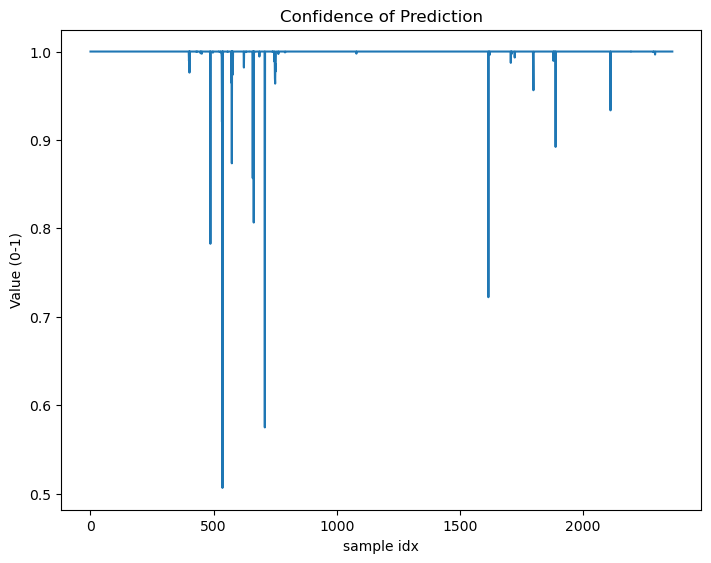

In [110]:
ensemble.evaluate(Yh_val,Y_val)
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)

In [111]:
#---------------MODEL6-----------------------------------------#

In [112]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp_9nzlw0c/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp_9nzlw0c/train/Aedes vexans/ = 4723.
No. of files in "/tmp/tmp_9nzlw0c/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp_9nzlw0c/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp_9nzlw0c/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp_9nzlw0c/val/Aedes vexans/ = 1178.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp_9nzlw0c/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp_9nzlw0c/train/Anopheles sinensis/ = 4745.
No. of files in "/tmp/tmp_9nzlw0c/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp_9nzlw0c/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp_9nzlw0c/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp_9nzlw0c/val/Anopheles sinensis/ = 1178.
Foun

((14329, 3538, 0), (9551, 2357, 0))

In [113]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 14329 files belonging to 6 classes.
Found 3538 files belonging to 6 classes.
Found 14329 files belonging to 6 classes.
Found 3538 files belonging to 6 classes.


In [114]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/18-02:50:40

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
1792/1792 [==============================] - 136s 71ms/step - loss: 1.7753 - accuracy: 0.2232 - val_loss: 1.3703 - val_accuracy: 0.4192 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
1792/1792 [==============================] - 126s 70ms/step - loss: 1.3118 - accuracy: 0.4300 - val_loss: 1.1860 - val_accuracy: 0.4664 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
1792/1792 [==============================] - 129s 72ms/step - loss: 0.9847 - accuracy: 0.6021 - val_loss: 0.7855 - val_accuracy: 0.7001 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
1792/1792 [==============================] - 126s 70ms/step - loss: 0.6945 - accuracy: 0.7315 - val_loss: 0.3860 - val_accuracy: 0.858

Epoch 34/40
1792/1792 [==============================] - 125s 69ms/step - loss: 0.0048 - accuracy: 0.9983 - val_loss: 0.0732 - val_accuracy: 0.9816 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
1792/1792 [==============================] - 129s 72ms/step - loss: 0.0040 - accuracy: 0.9989 - val_loss: 0.0732 - val_accuracy: 0.9822 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
1792/1792 [==============================] - 124s 69ms/step - loss: 0.0032 - accuracy: 0.9989 - val_loss: 0.0813 - val_accuracy: 0.9799 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
1792/1792 [==============================] - 124s 69ms/step - loss: 0.0037 - accuracy: 0.9985 - val_loss: 0.0741 - val_accuracy: 0.9825 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
1792

Maximum test accuracy is at 98.25 %.


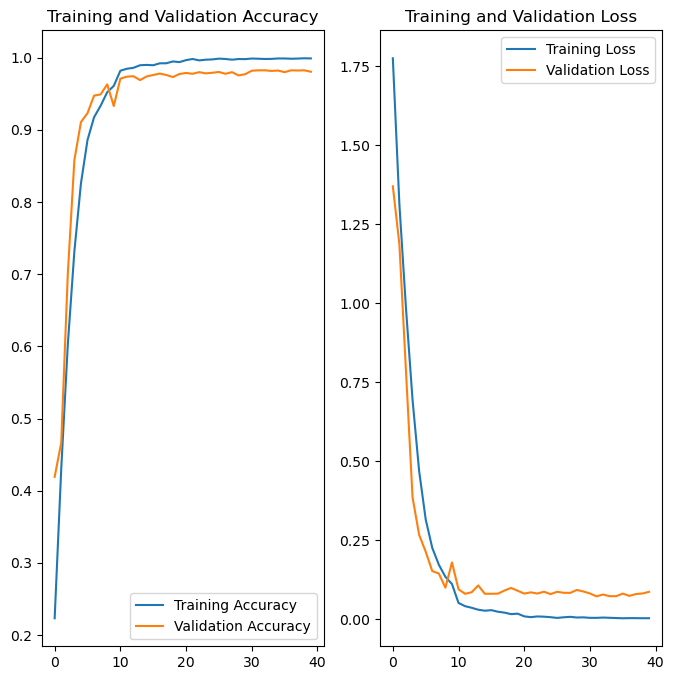

In [115]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [116]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

443/443 [==============================] - 10s 21ms/step
Confusion Matrix
[[587   2   0   1   0   1]
 [  0 569   2   0  15   3]
 [  0  13 572   0   3   1]
 [  0   0   0 594   0   0]
 [  0  16   0   0 571   0]
 [  0   4   3   5   0 576]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.99      1.00       591
           Aedes vexans       0.94      0.97      0.95       589
     Anopheles sinensis       0.99      0.97      0.98       589
          Culex pipiens       0.99      1.00      0.99       594
Culex tritaeniorhynchus       0.97      0.97      0.97       587
            Non vectors       0.99      0.98      0.99       588

               accuracy                           0.98      3538
              macro avg       0.98      0.98      0.98      3538
           weighted avg       0.98      0.98      0.98      3538

Model is saved in ./models/Model_Early_Combine_Park_2022-09-18_04-14.h5


In [117]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_16"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_320 (Conv2D)            (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                          

                                                                                                  
 max_pooling2d_115 (MaxPooling2  (None, 14, 14, 512)  0          ['conv2d_336[0][0]']             
 D)                                                                                               
                                                                                                  
 spatial_dropout2d_110 (Spatial  (None, 14, 14, 512)  0          ['max_pooling2d_115[0][0]']      
 Dropout2D)                                                                                       
                                                                                                  
 conv2d_337 (Conv2D)            (None, 14, 14, 512)  2359808     ['spatial_dropout2d_110[0][0]']  
                                                                                                  
 conv2d_338 (Conv2D)            (None, 14, 14, 512)  2359808     ['conv2d_337[0][0]']             
          

Maximum test accuracy is at 98.13 %.


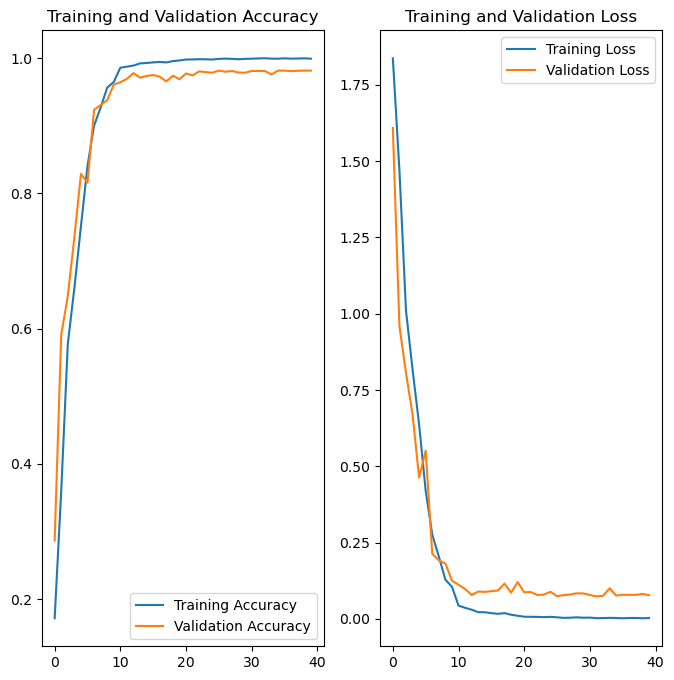

In [118]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [119]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

443/443 [==============================] - 11s 24ms/step
Confusion Matrix
[[589   1   0   0   0   1]
 [  1 564   4   0  17   3]
 [  0   8 576   0   4   1]
 [  0   2   1 590   0   1]
 [  0  12   0   0 575   0]
 [  0   4   2   4   0 578]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      1.00      1.00       591
           Aedes vexans       0.95      0.96      0.96       589
     Anopheles sinensis       0.99      0.98      0.98       589
          Culex pipiens       0.99      0.99      0.99       594
Culex tritaeniorhynchus       0.96      0.98      0.97       587
            Non vectors       0.99      0.98      0.99       588

               accuracy                           0.98      3538
              macro avg       0.98      0.98      0.98      3538
           weighted avg       0.98      0.98      0.98      3538

Model is saved in ./models/Model_Middle_Combine_Park_2022-09-18_05-54.h5


In [120]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_340 (Conv2D)            (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                          

 conv2d_360 (Conv2D)            (None, 28, 28, 512)  1180160     ['spatial_dropout2d_118[0][0]']  
                                                                                                  
 conv2d_348 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_347[0][0]']             
                                                                                                  
 conv2d_361 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_360[0][0]']             
                                                                                                  
 conv2d_349 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_348[0][0]']             
                                                                                                  
 conv2d_362 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_361[0][0]']             
                                                                                                  
 max_pooli

Epoch 12/40
1792/1792 [==============================] - 172s 96ms/step - loss: 0.0053 - accuracy: 0.9982 - val_loss: 0.0530 - val_accuracy: 0.9847 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
1792/1792 [==============================] - 176s 98ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0635 - val_accuracy: 0.9822 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
1792/1792 [==============================] - 172s 96ms/step - loss: 0.0040 - accuracy: 0.9988 - val_loss: 0.0710 - val_accuracy: 0.9808 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
1792/1792 [==============================] - 174s 97ms/step - loss: 0.0034 - accuracy: 0.9992 - val_loss: 0.0653 - val_accuracy: 0.9811 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
1792

Maximum test accuracy is at 98.64 %.


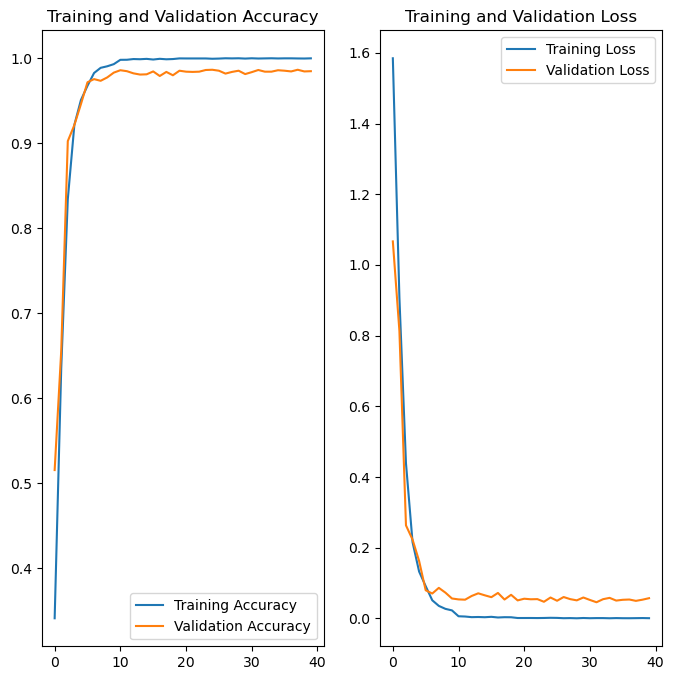

In [121]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [122]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----



443/443 [==============================] - 12s 27ms/step
Confusion Matrix
[[590   0   0   0   0   1]
 [  0 564   1   0  21   3]
 [  0   1 587   0   1   0]
 [  0   3   4 586   0   1]
 [  0   4   0   0 583   0]
 [  0   3   2   3   0 580]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      1.00      1.00       591
           Aedes vexans       0.98      0.96      0.97       589
     Anopheles sinensis       0.99      1.00      0.99       589
          Culex pipiens       0.99      0.99      0.99       594
Culex tritaeniorhynchus       0.96      0.99      0.98       587
            Non vectors       0.99      0.99      0.99       588

               accuracy                           0.99      3538
              macro avg       0.99      0.99      0.99      3538
           weighted avg       0.99      0.99      0.99      3538

Model is saved in ./models/Model_Late_Combine_Park_2022-09-18_07-50.h5


In [123]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 9551 files belonging to 6 classes.
Found 2357 files belonging to 6 classes.
Found 9551 files belonging to 6 classes.
Found 2357 files belonging to 6 classes.
Found 9551 files belonging to 6 classes.
Found 2357 files belonging to 6 classes.


In [124]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

295/295 [==============================] - 9s 28ms/step


In [125]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
597/597 [==============================] - 3s 4ms/step - loss: 0.3486 - accuracy: 0.9094
Epoch 2/20
597/597 [==============================] - 3s 4ms/step - loss: 0.0066 - accuracy: 0.9997
Epoch 3/20
597/597 [==============================] - 3s 4ms/step - loss: 0.0025 - accuracy: 0.9997
Epoch 4/20
597/597 [==============================] - 3s 4ms/step - loss: 0.0015 - accuracy: 0.9999
Epoch 5/20
597/597 [==============================] - 3s 4ms/step - loss: 9.9110e-04 - accuracy: 0.9999
Epoch 6/20
597/597 [==============================] - 3s 4ms/step - loss: 7.4188e-04 - accuracy: 0.9999
Epoch 7/20
597/597 [==============================] - 2s 4ms/step - loss: 5.8884e-04 - accuracy: 0.9998
Epoch 8/20
597/597 [==============================] - 3s 4ms/step - loss: 5.0732e-04 - accuracy: 0.9998
Epoch 9/20
597/597 [==============================] - 3s 4ms/step - loss: 4.0250e-04 - accuracy: 0.9999
Epoch 10/20
597/597 [==============================] - 3s 4ms/step - loss: 3.485

74/74 [==============================] - 0s 2ms/step


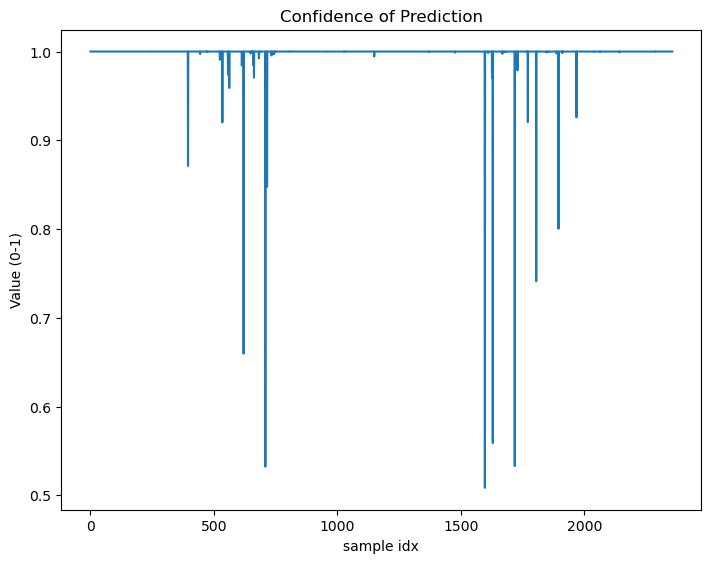

In [126]:
ensemble.evaluate(Yh_val,Y_val)
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)

In [127]:
#---------------MODEL7-----------------------------------------#

In [128]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp0qo5dczz/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp0qo5dczz/train/Aedes vexans/ = 4737.
No. of files in "/tmp/tmp0qo5dczz/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp0qo5dczz/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp0qo5dczz/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp0qo5dczz/val/Aedes vexans/ = 1164.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp0qo5dczz/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp0qo5dczz/train/Anopheles sinensis/ = 4745.
No. of files in "/tmp/tmp0qo5dczz/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp0qo5dczz/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp0qo5dczz/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp0qo5dczz/val/Anopheles sinensis/ = 1178.
Foun

((14341, 3526, 0), (9560, 2350, 0))

In [129]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 14341 files belonging to 6 classes.
Found 3526 files belonging to 6 classes.
Found 14341 files belonging to 6 classes.
Found 3526 files belonging to 6 classes.


In [130]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/18-08:03:57

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
1793/1793 [==============================] - 137s 71ms/step - loss: 1.7801 - accuracy: 0.2233 - val_loss: 1.3649 - val_accuracy: 0.3653 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
1793/1793 [==============================] - 128s 72ms/step - loss: 1.2751 - accuracy: 0.4505 - val_loss: 1.0284 - val_accuracy: 0.5905 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
1793/1793 [==============================] - 125s 70ms/step - loss: 1.0121 - accuracy: 0.5853 - val_loss: 0.7935 - val_accuracy: 0.6758 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
1793/1793 [==============================] - 127s 71ms/step - loss: 0.7668 - accuracy: 0.6947 - val_loss: 0.5864 - val_accuracy: 0.749

Epoch 34/40
1793/1793 [==============================] - 125s 70ms/step - loss: 0.0052 - accuracy: 0.9985 - val_loss: 0.0795 - val_accuracy: 0.9776 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
1793/1793 [==============================] - 126s 70ms/step - loss: 0.0044 - accuracy: 0.9991 - val_loss: 0.0765 - val_accuracy: 0.9790 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
1793/1793 [==============================] - 132s 74ms/step - loss: 0.0038 - accuracy: 0.9992 - val_loss: 0.0727 - val_accuracy: 0.9793 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
1793/1793 [==============================] - 126s 70ms/step - loss: 0.0045 - accuracy: 0.9985 - val_loss: 0.0767 - val_accuracy: 0.9790 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
1793

Maximum test accuracy is at 98.27 %.


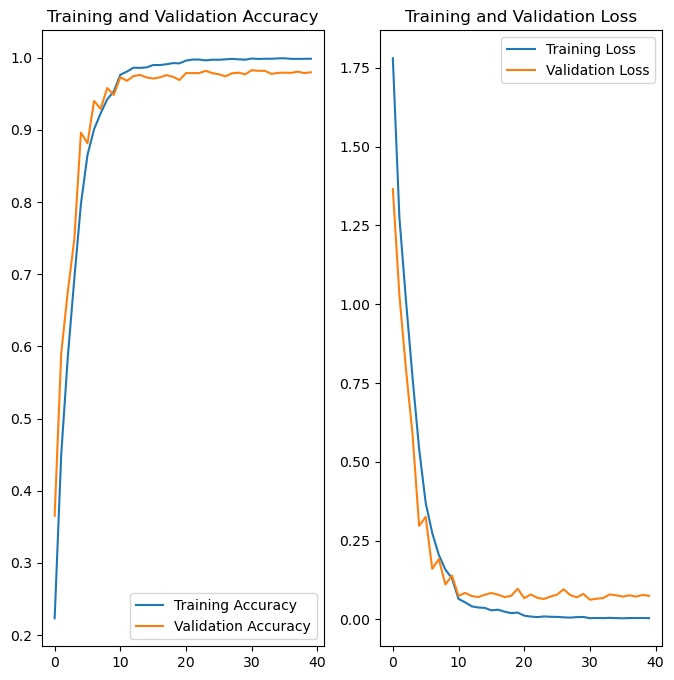

In [131]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [132]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

441/441 [==============================] - 10s 22ms/step
Confusion Matrix
[[596   2   0   0   0   1]
 [  0 561   2   1  18   0]
 [  0   7 582   0   0   0]
 [  0   2   0 590   0   0]
 [  0  30   0   1 563   0]
 [  0   3   0   4   0 563]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.99      1.00       599
           Aedes vexans       0.93      0.96      0.95       582
     Anopheles sinensis       1.00      0.99      0.99       589
          Culex pipiens       0.99      1.00      0.99       592
Culex tritaeniorhynchus       0.97      0.95      0.96       594
            Non vectors       1.00      0.99      0.99       570

               accuracy                           0.98      3526
              macro avg       0.98      0.98      0.98      3526
           weighted avg       0.98      0.98      0.98      3526

Model is saved in ./models/Model_Early_Combine_Park_2022-09-18_09-28.h5


In [133]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_19"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_381 (Conv2D)            (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                          

                                                                                                  
 max_pooling2d_136 (MaxPooling2  (None, 14, 14, 512)  0          ['conv2d_397[0][0]']             
 D)                                                                                               
                                                                                                  
 spatial_dropout2d_130 (Spatial  (None, 14, 14, 512)  0          ['max_pooling2d_136[0][0]']      
 Dropout2D)                                                                                       
                                                                                                  
 conv2d_398 (Conv2D)            (None, 14, 14, 512)  2359808     ['spatial_dropout2d_130[0][0]']  
                                                                                                  
 conv2d_399 (Conv2D)            (None, 14, 14, 512)  2359808     ['conv2d_398[0][0]']             
          

Maximum test accuracy is at 98.44 %.


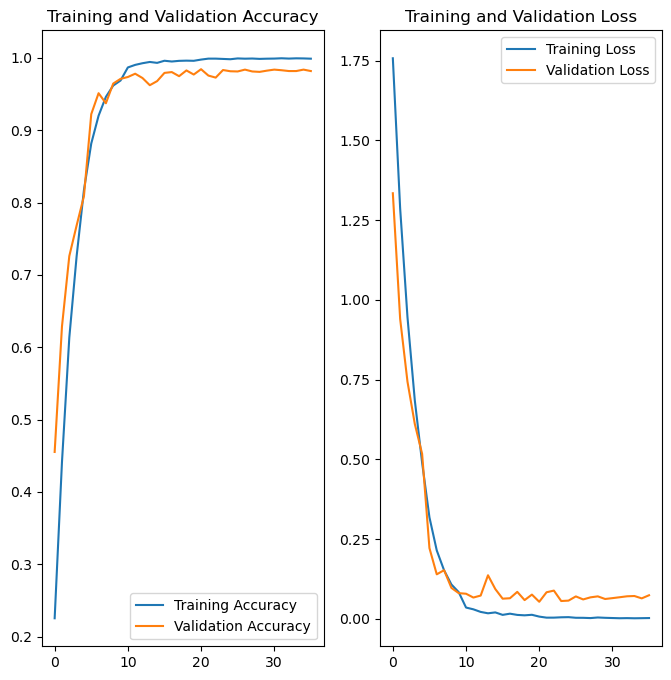

In [134]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [135]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

441/441 [==============================] - 11s 23ms/step
Confusion Matrix
[[596   3   0   0   0   0]
 [  0 573   0   0   8   1]
 [  0   4 584   0   0   1]
 [  0   1   0 591   0   0]
 [  0  27   0   0 567   0]
 [  1   6   0   3   0 560]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.99      1.00       599
           Aedes vexans       0.93      0.98      0.96       582
     Anopheles sinensis       1.00      0.99      1.00       589
          Culex pipiens       0.99      1.00      1.00       592
Culex tritaeniorhynchus       0.99      0.95      0.97       594
            Non vectors       1.00      0.98      0.99       570

               accuracy                           0.98      3526
              macro avg       0.98      0.98      0.98      3526
           weighted avg       0.98      0.98      0.98      3526

Model is saved in ./models/Model_Middle_Combine_Park_2022-09-18_11-01.h5


In [136]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_20"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_401 (Conv2D)            (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                          

 conv2d_421 (Conv2D)            (None, 28, 28, 512)  1180160     ['spatial_dropout2d_138[0][0]']  
                                                                                                  
 conv2d_409 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_408[0][0]']             
                                                                                                  
 conv2d_422 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_421[0][0]']             
                                                                                                  
 conv2d_410 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_409[0][0]']             
                                                                                                  
 conv2d_423 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_422[0][0]']             
                                                                                                  
 max_pooli

Epoch 12/40
1793/1793 [==============================] - 177s 99ms/step - loss: 0.0061 - accuracy: 0.9983 - val_loss: 0.0914 - val_accuracy: 0.9719 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
1793/1793 [==============================] - 176s 98ms/step - loss: 0.0034 - accuracy: 0.9988 - val_loss: 0.0568 - val_accuracy: 0.9813 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
1793/1793 [==============================] - 177s 98ms/step - loss: 0.0046 - accuracy: 0.9985 - val_loss: 0.0436 - val_accuracy: 0.9884 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
1793/1793 [==============================] - 179s 100ms/step - loss: 0.0024 - accuracy: 0.9996 - val_loss: 0.0567 - val_accuracy: 0.9833 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
179

Maximum test accuracy is at 98.87 %.


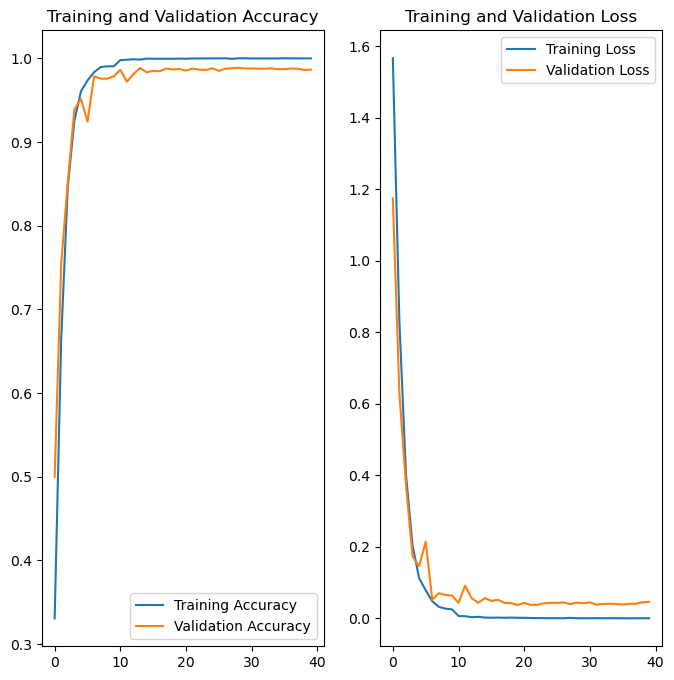

In [137]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [138]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

441/441 [==============================] - 13s 28ms/step
Confusion Matrix
[[598   1   0   0   0   0]
 [  0 576   0   0   5   1]
 [  0   0 588   0   0   1]
 [  0   0   0 592   0   0]
 [  0  15   0   0 579   0]
 [  0   5   3  17   0 545]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      1.00      1.00       599
           Aedes vexans       0.96      0.99      0.98       582
     Anopheles sinensis       0.99      1.00      1.00       589
          Culex pipiens       0.97      1.00      0.99       592
Culex tritaeniorhynchus       0.99      0.97      0.98       594
            Non vectors       1.00      0.96      0.98       570

               accuracy                           0.99      3526
              macro avg       0.99      0.99      0.99      3526
           weighted avg       0.99      0.99      0.99      3526

Model is saved in ./models/Model_Late_Combine_Park_2022-09-18_12-59.h5


In [139]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 9560 files belonging to 6 classes.
Found 2350 files belonging to 6 classes.
Found 9560 files belonging to 6 classes.
Found 2350 files belonging to 6 classes.
Found 9560 files belonging to 6 classes.
Found 2350 files belonging to 6 classes.


In [140]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

294/294 [==============================] - 9s 28ms/step


In [141]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
598/598 [==============================] - 3s 4ms/step - loss: 0.4454 - accuracy: 0.8353
Epoch 2/20
598/598 [==============================] - 3s 5ms/step - loss: 0.0093 - accuracy: 0.9998
Epoch 3/20
598/598 [==============================] - 3s 5ms/step - loss: 0.0030 - accuracy: 1.0000
Epoch 4/20
598/598 [==============================] - 3s 5ms/step - loss: 0.0015 - accuracy: 1.0000
Epoch 5/20
598/598 [==============================] - 3s 5ms/step - loss: 8.5184e-04 - accuracy: 1.0000
Epoch 6/20
598/598 [==============================] - 3s 5ms/step - loss: 5.3173e-04 - accuracy: 1.0000
Epoch 7/20
598/598 [==============================] - 3s 5ms/step - loss: 3.4916e-04 - accuracy: 1.0000
Epoch 8/20
598/598 [==============================] - 3s 5ms/step - loss: 2.3824e-04 - accuracy: 1.0000
Epoch 9/20
598/598 [==============================] - 3s 5ms/step - loss: 1.6521e-04 - accuracy: 1.0000
Epoch 10/20
598/598 [==============================] - 3s 5ms/step - loss: 1.158

74/74 [==============================] - 0s 2ms/step


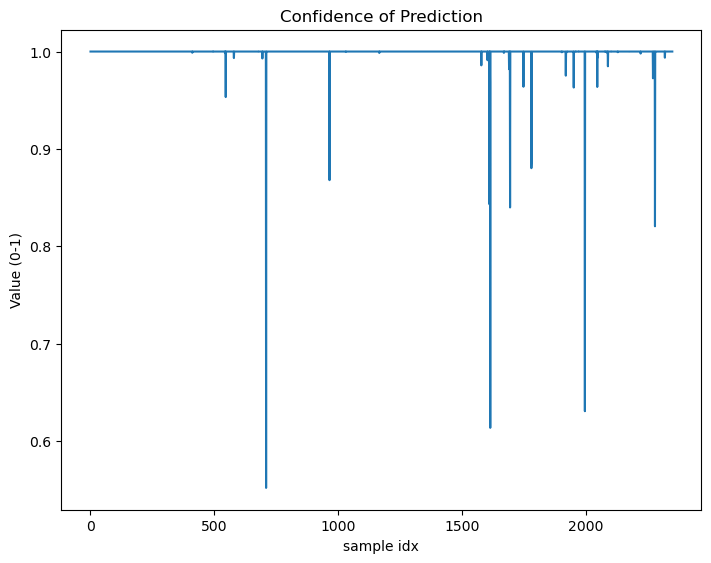

In [142]:
ensemble.evaluate(Yh_val,Y_val)
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)

In [143]:
#---------------MODEL8-----------------------------------------#

In [144]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp2571gf5a/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp2571gf5a/train/Aedes vexans/ = 4729.
No. of files in "/tmp/tmp2571gf5a/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp2571gf5a/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp2571gf5a/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp2571gf5a/val/Aedes vexans/ = 1172.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp2571gf5a/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp2571gf5a/train/Anopheles sinensis/ = 4748.
No. of files in "/tmp/tmp2571gf5a/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp2571gf5a/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp2571gf5a/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp2571gf5a/val/Anopheles sinensis/ = 1175.
Foun

((14334, 3534, 0), (9554, 2353, 0))

In [145]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 14334 files belonging to 6 classes.
Found 3534 files belonging to 6 classes.
Found 14334 files belonging to 6 classes.
Found 3534 files belonging to 6 classes.


In [146]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/18-13:12:44

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
1792/1792 [==============================] - 139s 73ms/step - loss: 1.5214 - accuracy: 0.3704 - val_loss: 1.1359 - val_accuracy: 0.5204 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
1792/1792 [==============================] - 125s 70ms/step - loss: 0.9314 - accuracy: 0.6307 - val_loss: 0.6374 - val_accuracy: 0.7507 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
1792/1792 [==============================] - 125s 70ms/step - loss: 0.5820 - accuracy: 0.7796 - val_loss: 0.4202 - val_accuracy: 0.8435 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
1792/1792 [==============================] - 130s 72ms/step - loss: 0.3494 - accuracy: 0.8703 - val_loss: 0.4057 - val_accuracy: 0.854

Epoch 34/40
1792/1792 [==============================] - 127s 71ms/step - loss: 0.0015 - accuracy: 0.9997 - val_loss: 0.1069 - val_accuracy: 0.9768 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
1792/1792 [==============================] - 124s 69ms/step - loss: 0.0023 - accuracy: 0.9992 - val_loss: 0.1010 - val_accuracy: 0.9776 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
1792/1792 [==============================] - 124s 69ms/step - loss: 0.0022 - accuracy: 0.9991 - val_loss: 0.1086 - val_accuracy: 0.9748 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
1792/1792 [==============================] - 125s 69ms/step - loss: 0.0027 - accuracy: 0.9992 - val_loss: 0.0961 - val_accuracy: 0.9793 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
1792

Maximum test accuracy is at 97.93 %.


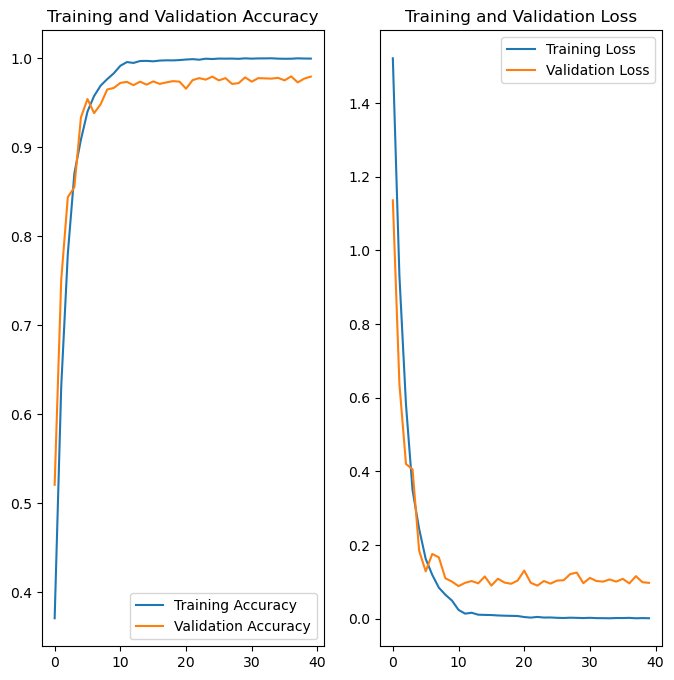

In [147]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [148]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

442/442 [==============================] - 10s 21ms/step
Confusion Matrix
[[578   3   0   0   0   0]
 [  0 573   7   0   6   0]
 [  0  18 564   0   3   2]
 [  0   0   0 593   0   0]
 [  0  20   0   0 569   0]
 [  0   2   1  12   0 583]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.99      1.00       581
           Aedes vexans       0.93      0.98      0.95       586
     Anopheles sinensis       0.99      0.96      0.97       587
          Culex pipiens       0.98      1.00      0.99       593
Culex tritaeniorhynchus       0.98      0.97      0.98       589
            Non vectors       1.00      0.97      0.99       598

               accuracy                           0.98      3534
              macro avg       0.98      0.98      0.98      3534
           weighted avg       0.98      0.98      0.98      3534

Model is saved in ./models/Model_Early_Combine_Park_2022-09-18_14-36.h5


In [149]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_22"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_442 (Conv2D)            (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                          

                                                                                                  
 max_pooling2d_157 (MaxPooling2  (None, 14, 14, 512)  0          ['conv2d_458[0][0]']             
 D)                                                                                               
                                                                                                  
 spatial_dropout2d_150 (Spatial  (None, 14, 14, 512)  0          ['max_pooling2d_157[0][0]']      
 Dropout2D)                                                                                       
                                                                                                  
 conv2d_459 (Conv2D)            (None, 14, 14, 512)  2359808     ['spatial_dropout2d_150[0][0]']  
                                                                                                  
 conv2d_460 (Conv2D)            (None, 14, 14, 512)  2359808     ['conv2d_459[0][0]']             
          

Maximum test accuracy is at 97.71 %.


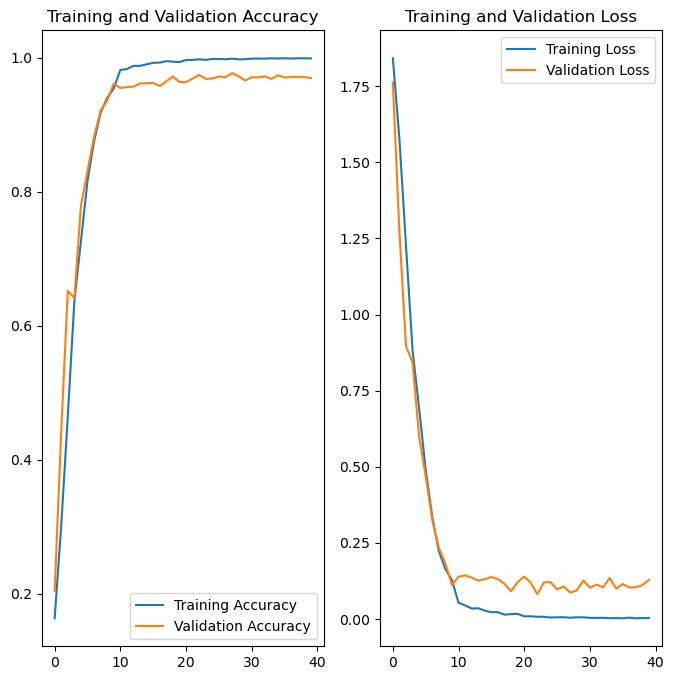

In [150]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [151]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

442/442 [==============================] - 11s 24ms/step
Confusion Matrix
[[578   3   0   0   0   0]
 [  1 572   3   1   3   6]
 [  0  25 557   0   5   0]
 [  0   1   0 592   0   0]
 [  0  29   0   0 560   0]
 [  0  14   0  16   0 568]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.99      1.00       581
           Aedes vexans       0.89      0.98      0.93       586
     Anopheles sinensis       0.99      0.95      0.97       587
          Culex pipiens       0.97      1.00      0.99       593
Culex tritaeniorhynchus       0.99      0.95      0.97       589
            Non vectors       0.99      0.95      0.97       598

               accuracy                           0.97      3534
              macro avg       0.97      0.97      0.97      3534
           weighted avg       0.97      0.97      0.97      3534

Model is saved in ./models/Model_Middle_Combine_Park_2022-09-18_16-17.h5


In [152]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_23"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_462 (Conv2D)            (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                          

 conv2d_482 (Conv2D)            (None, 28, 28, 512)  1180160     ['spatial_dropout2d_158[0][0]']  
                                                                                                  
 conv2d_470 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_469[0][0]']             
                                                                                                  
 conv2d_483 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_482[0][0]']             
                                                                                                  
 conv2d_471 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_470[0][0]']             
                                                                                                  
 conv2d_484 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_483[0][0]']             
                                                                                                  
 max_pooli

Epoch 12/40
1792/1792 [==============================] - 175s 98ms/step - loss: 0.0056 - accuracy: 0.9983 - val_loss: 0.0729 - val_accuracy: 0.9779 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
1792/1792 [==============================] - 173s 97ms/step - loss: 0.0037 - accuracy: 0.9989 - val_loss: 0.1015 - val_accuracy: 0.9694 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
1792/1792 [==============================] - 171s 95ms/step - loss: 0.0042 - accuracy: 0.9990 - val_loss: 0.0750 - val_accuracy: 0.9771 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
1792/1792 [==============================] - 172s 96ms/step - loss: 0.0043 - accuracy: 0.9985 - val_loss: 0.0912 - val_accuracy: 0.9737 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
1792

Maximum test accuracy is at 98.67 %.


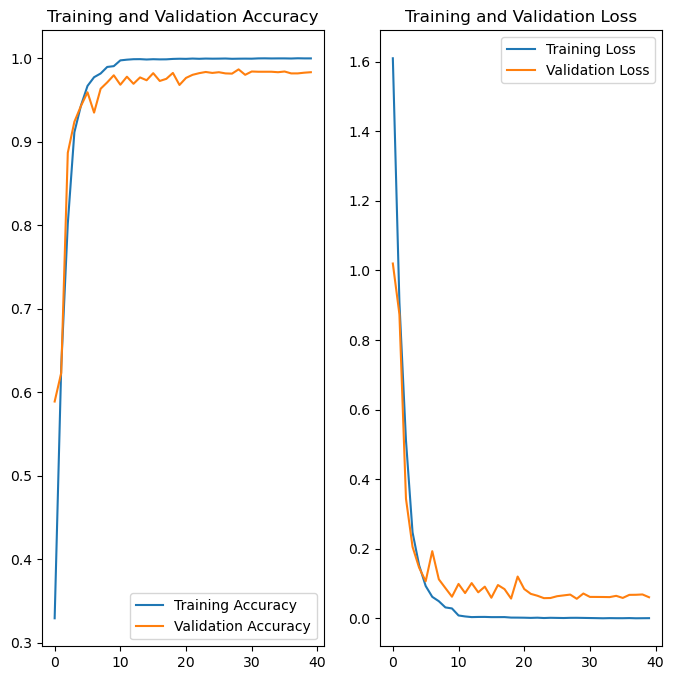

In [153]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [154]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

442/442 [==============================] - 12s 27ms/step
Confusion Matrix
[[579   2   0   0   0   0]
 [  0 579   0   0   4   3]
 [  0  13 571   0   0   3]
 [  0   0   1 592   0   0]
 [  0  11   0   0 578   0]
 [  0  12   0  10   0 576]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      1.00      1.00       581
           Aedes vexans       0.94      0.99      0.96       586
     Anopheles sinensis       1.00      0.97      0.99       587
          Culex pipiens       0.98      1.00      0.99       593
Culex tritaeniorhynchus       0.99      0.98      0.99       589
            Non vectors       0.99      0.96      0.98       598

               accuracy                           0.98      3534
              macro avg       0.98      0.98      0.98      3534
           weighted avg       0.98      0.98      0.98      3534

Model is saved in ./models/Model_Late_Combine_Park_2022-09-18_18-12.h5


In [155]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 9554 files belonging to 6 classes.
Found 2353 files belonging to 6 classes.
Found 9554 files belonging to 6 classes.
Found 2353 files belonging to 6 classes.
Found 9554 files belonging to 6 classes.
Found 2353 files belonging to 6 classes.


In [156]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

295/295 [==============================] - 9s 29ms/step


In [157]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
598/598 [==============================] - 3s 4ms/step - loss: 0.5674 - accuracy: 0.8829
Epoch 2/20
598/598 [==============================] - 2s 4ms/step - loss: 0.1689 - accuracy: 0.9990
Epoch 3/20
598/598 [==============================] - 3s 4ms/step - loss: 0.1010 - accuracy: 0.9998
Epoch 4/20
598/598 [==============================] - 3s 4ms/step - loss: 0.0614 - accuracy: 0.9999
Epoch 5/20
598/598 [==============================] - 3s 4ms/step - loss: 0.0386 - accuracy: 1.0000
Epoch 6/20
598/598 [==============================] - 3s 4ms/step - loss: 0.0254 - accuracy: 1.0000
Epoch 7/20
598/598 [==============================] - 3s 4ms/step - loss: 0.0173 - accuracy: 1.0000
Epoch 8/20
598/598 [==============================] - 3s 4ms/step - loss: 0.0121 - accuracy: 1.0000
Epoch 9/20
598/598 [==============================] - 2s 4ms/step - loss: 0.0086 - accuracy: 1.0000
Epoch 10/20
598/598 [==============================] - 2s 3ms/step - loss: 0.0062 - accuracy: 1.0000

74/74 [==============================] - 0s 2ms/step


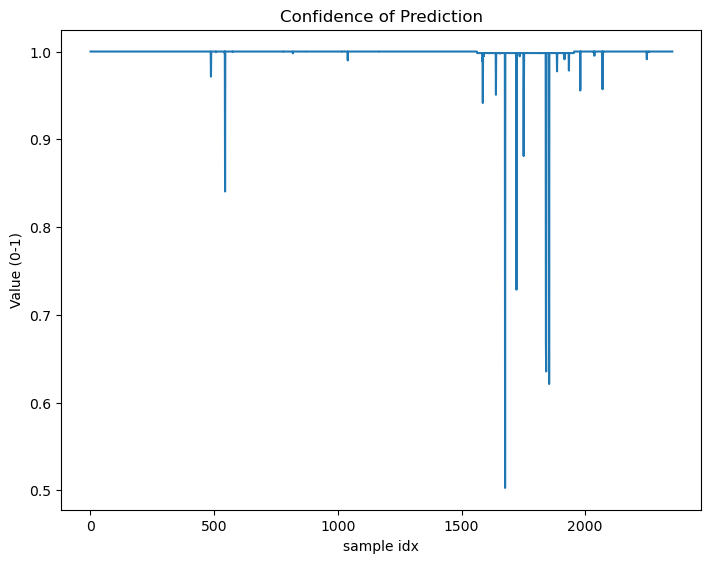

In [158]:
ensemble.evaluate(Yh_val,Y_val)
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)

In [159]:
#---------------MODEL9-----------------------------------------#

In [160]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp5_wqi6ac/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp5_wqi6ac/train/Aedes vexans/ = 4725.
No. of files in "/tmp/tmp5_wqi6ac/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp5_wqi6ac/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp5_wqi6ac/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp5_wqi6ac/val/Aedes vexans/ = 1176.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp5_wqi6ac/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp5_wqi6ac/train/Anopheles sinensis/ = 4751.
No. of files in "/tmp/tmp5_wqi6ac/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp5_wqi6ac/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp5_wqi6ac/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp5_wqi6ac/val/Anopheles sinensis/ = 1172.
Foun

((14331, 3536, 0), (9554, 2356, 0))

In [161]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 14331 files belonging to 6 classes.
Found 3536 files belonging to 6 classes.
Found 14331 files belonging to 6 classes.
Found 3536 files belonging to 6 classes.


In [162]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/18-18:26:05

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
1792/1792 [==============================] - 137s 72ms/step - loss: 1.8429 - accuracy: 0.1876 - val_loss: 1.6318 - val_accuracy: 0.3255 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
1792/1792 [==============================] - 128s 72ms/step - loss: 1.4443 - accuracy: 0.3716 - val_loss: 1.0986 - val_accuracy: 0.5362 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
1792/1792 [==============================] - 129s 72ms/step - loss: 1.1120 - accuracy: 0.5406 - val_loss: 0.9977 - val_accuracy: 0.5563 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
1792/1792 [==============================] - 124s 69ms/step - loss: 0.8906 - accuracy: 0.6476 - val_loss: 0.6385 - val_accuracy: 0.731

Epoch 34/40
1792/1792 [==============================] - 127s 71ms/step - loss: 0.0058 - accuracy: 0.9981 - val_loss: 0.0613 - val_accuracy: 0.9847 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
1792/1792 [==============================] - 130s 72ms/step - loss: 0.0069 - accuracy: 0.9978 - val_loss: 0.0586 - val_accuracy: 0.9836 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
1792/1792 [==============================] - 126s 70ms/step - loss: 0.0082 - accuracy: 0.9973 - val_loss: 0.0570 - val_accuracy: 0.9833 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
1792/1792 [==============================] - 126s 70ms/step - loss: 0.0084 - accuracy: 0.9971 - val_loss: 0.0565 - val_accuracy: 0.9853 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
1792

Maximum test accuracy is at 98.56 %.


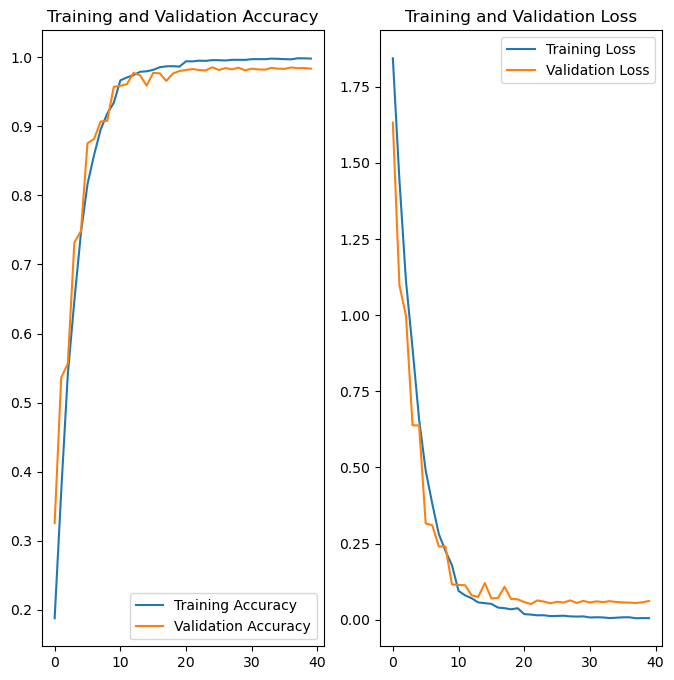

In [163]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [164]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

442/442 [==============================] - 10s 21ms/step
Confusion Matrix
[[588   1   1   0   0   1]
 [  0 566   2   4  14   2]
 [  0   4 582   0   0   0]
 [  0   3   0 590   0   0]
 [  0  13   0   0 573   0]
 [  0   2   0   4   0 586]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.99      1.00       591
           Aedes vexans       0.96      0.96      0.96       588
     Anopheles sinensis       0.99      0.99      0.99       586
          Culex pipiens       0.99      0.99      0.99       593
Culex tritaeniorhynchus       0.98      0.98      0.98       586
            Non vectors       0.99      0.99      0.99       592

               accuracy                           0.99      3536
              macro avg       0.99      0.99      0.99      3536
           weighted avg       0.99      0.99      0.99      3536

Model is saved in ./models/Model_Early_Combine_Park_2022-09-18_19-51.h5


In [165]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_25"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_503 (Conv2D)            (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                          

                                                                                                  
 max_pooling2d_178 (MaxPooling2  (None, 14, 14, 512)  0          ['conv2d_519[0][0]']             
 D)                                                                                               
                                                                                                  
 spatial_dropout2d_170 (Spatial  (None, 14, 14, 512)  0          ['max_pooling2d_178[0][0]']      
 Dropout2D)                                                                                       
                                                                                                  
 conv2d_520 (Conv2D)            (None, 14, 14, 512)  2359808     ['spatial_dropout2d_170[0][0]']  
                                                                                                  
 conv2d_521 (Conv2D)            (None, 14, 14, 512)  2359808     ['conv2d_520[0][0]']             
          

Maximum test accuracy is at 98.76 %.


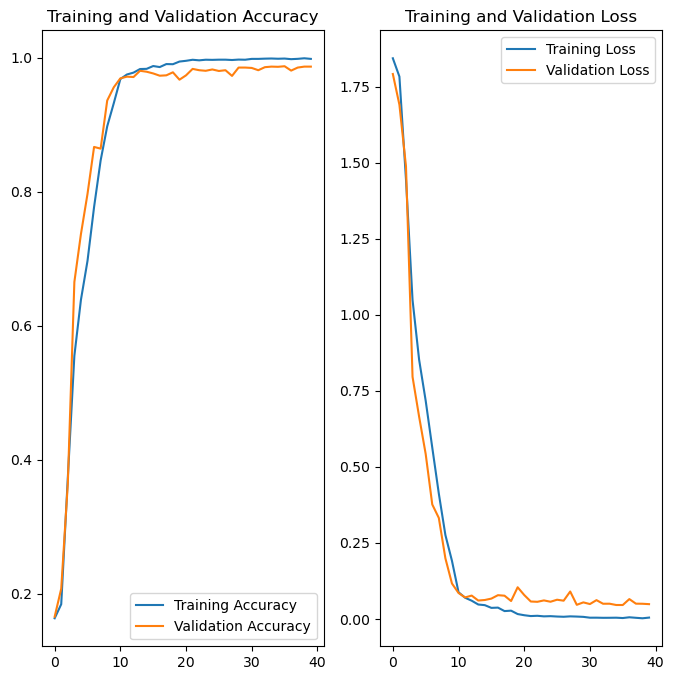

In [166]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [167]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

442/442 [==============================] - 11s 23ms/step
Confusion Matrix
[[589   2   0   0   0   0]
 [  0 576   2   0   8   2]
 [  0   6 580   0   0   0]
 [  1   2   2 588   0   0]
 [  0  15   0   0 571   0]
 [  0   2   1   2   1 586]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      1.00      1.00       591
           Aedes vexans       0.96      0.98      0.97       588
     Anopheles sinensis       0.99      0.99      0.99       586
          Culex pipiens       1.00      0.99      0.99       593
Culex tritaeniorhynchus       0.98      0.97      0.98       586
            Non vectors       1.00      0.99      0.99       592

               accuracy                           0.99      3536
              macro avg       0.99      0.99      0.99      3536
           weighted avg       0.99      0.99      0.99      3536

Model is saved in ./models/Model_Middle_Combine_Park_2022-09-18_21-33.h5


In [168]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_523 (Conv2D)            (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                          

 conv2d_543 (Conv2D)            (None, 28, 28, 512)  1180160     ['spatial_dropout2d_178[0][0]']  
                                                                                                  
 conv2d_531 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_530[0][0]']             
                                                                                                  
 conv2d_544 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_543[0][0]']             
                                                                                                  
 conv2d_532 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_531[0][0]']             
                                                                                                  
 conv2d_545 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_544[0][0]']             
                                                                                                  
 max_pooli

Epoch 12/40
1792/1792 [==============================] - 181s 101ms/step - loss: 0.0047 - accuracy: 0.9985 - val_loss: 0.0428 - val_accuracy: 0.9878 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
1792/1792 [==============================] - 174s 97ms/step - loss: 0.0036 - accuracy: 0.9992 - val_loss: 0.0517 - val_accuracy: 0.9859 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
1792/1792 [==============================] - 174s 97ms/step - loss: 0.0025 - accuracy: 0.9995 - val_loss: 0.0491 - val_accuracy: 0.9870 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
1792/1792 [==============================] - 181s 101ms/step - loss: 0.0030 - accuracy: 0.9993 - val_loss: 0.0511 - val_accuracy: 0.9873 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
17

Maximum test accuracy is at 98.93 %.


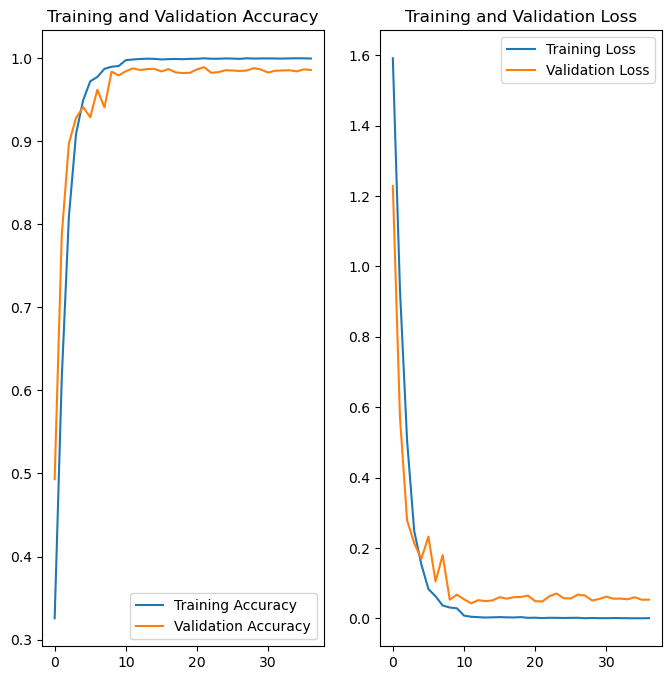

In [169]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [170]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

442/442 [==============================] - 12s 27ms/step
Confusion Matrix
[[586   5   0   0   0   0]
 [  2 578   0   0   4   4]
 [  0   2 584   0   0   0]
 [  0   1   1 591   0   0]
 [  0   7   0   0 579   0]
 [  0   4   2   5   1 580]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.99      0.99       591
           Aedes vexans       0.97      0.98      0.98       588
     Anopheles sinensis       0.99      1.00      1.00       586
          Culex pipiens       0.99      1.00      0.99       593
Culex tritaeniorhynchus       0.99      0.99      0.99       586
            Non vectors       0.99      0.98      0.99       592

               accuracy                           0.99      3536
              macro avg       0.99      0.99      0.99      3536
           weighted avg       0.99      0.99      0.99      3536

Model is saved in ./models/Model_Late_Combine_Park_2022-09-18_23-23.h5


In [171]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 9554 files belonging to 6 classes.
Found 2356 files belonging to 6 classes.
Found 9554 files belonging to 6 classes.
Found 2356 files belonging to 6 classes.
Found 9554 files belonging to 6 classes.
Found 2356 files belonging to 6 classes.


In [172]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

295/295 [==============================] - 8s 28ms/step


In [173]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
598/598 [==============================] - 3s 4ms/step - loss: 0.3536 - accuracy: 0.9429
Epoch 2/20
598/598 [==============================] - 2s 4ms/step - loss: 0.0093 - accuracy: 0.9998
Epoch 3/20
598/598 [==============================] - 2s 3ms/step - loss: 0.0025 - accuracy: 0.9999
Epoch 4/20
598/598 [==============================] - 2s 4ms/step - loss: 0.0012 - accuracy: 0.9999
Epoch 5/20
598/598 [==============================] - 3s 4ms/step - loss: 7.1405e-04 - accuracy: 0.9999
Epoch 6/20
598/598 [==============================] - 3s 4ms/step - loss: 5.0476e-04 - accuracy: 0.9999
Epoch 7/20
598/598 [==============================] - 3s 4ms/step - loss: 3.4679e-04 - accuracy: 1.0000
Epoch 8/20
598/598 [==============================] - 3s 4ms/step - loss: 2.5169e-04 - accuracy: 1.0000
Epoch 9/20
598/598 [==============================] - 3s 4ms/step - loss: 1.7728e-04 - accuracy: 1.0000
Epoch 10/20
598/598 [==============================] - 3s 4ms/step - loss: 1.512

74/74 [==============================] - 0s 2ms/step


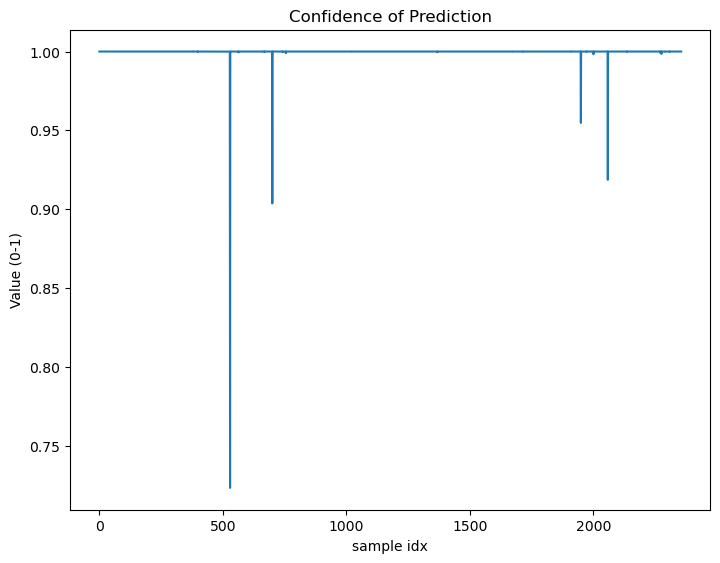

In [174]:
ensemble.evaluate(Yh_val,Y_val)
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)

In [175]:
#---------------MODEL 10-----------------------------------------#

In [176]:
split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

Ratio = (0.8, 0.2, -0.0).
Found Aedes vexans
No. of files in Aedes vexans = 5901.
No. of files in "/tmp/tmp2iy75mgb/train/Aedes vexans/" should be around 4721.
No. of files in /tmp/tmp2iy75mgb/train/Aedes vexans/ = 4725.
No. of files in "/tmp/tmp2iy75mgb/test/Aedes vexans/" should be around 0.
No. of files in /tmp/tmp2iy75mgb/test/Aedes vexans/ = 0.
No. of files in "/tmp/tmp2iy75mgb/val/Aedes vexans/" should be around 1181.
No. of files in /tmp/tmp2iy75mgb/val/Aedes vexans/ = 1176.
Found Anopheles sinensis
No. of files in Anopheles sinensis = 5923.
No. of files in "/tmp/tmp2iy75mgb/train/Anopheles sinensis/" should be around 4739.
No. of files in /tmp/tmp2iy75mgb/train/Anopheles sinensis/ = 4749.
No. of files in "/tmp/tmp2iy75mgb/test/Anopheles sinensis/" should be around 0.
No. of files in /tmp/tmp2iy75mgb/test/Anopheles sinensis/ = 0.
No. of files in "/tmp/tmp2iy75mgb/val/Anopheles sinensis/" should be around 1185.
No. of files in /tmp/tmp2iy75mgb/val/Anopheles sinensis/ = 1174.
Foun

((14338, 3530, 0), (9558, 2352, 0))

In [177]:
(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----

Found 14338 files belonging to 6 classes.
Found 3530 files belonging to 6 classes.
Found 14338 files belonging to 6 classes.
Found 3530 files belonging to 6 classes.


In [191]:
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Start fitting from 2022/09/19-08:20:44

Epoch 1: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 1/40
1793/1793 [==============================] - 145s 80ms/step - loss: 1.7153 - accuracy: 0.2586 - val_loss: 1.3244 - val_accuracy: 0.4011 - lr: 2.0000e-05

Epoch 2: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 2/40
1793/1793 [==============================] - 130s 73ms/step - loss: 1.1680 - accuracy: 0.5198 - val_loss: 0.8870 - val_accuracy: 0.6212 - lr: 2.0000e-05

Epoch 3: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 3/40
1793/1793 [==============================] - 130s 73ms/step - loss: 0.7845 - accuracy: 0.6902 - val_loss: 0.5394 - val_accuracy: 0.7952 - lr: 2.0000e-05

Epoch 4: LearningRateScheduler setting learning rate to 1.9999999494757503e-05.
Epoch 4/40
1793/1793 [==============================] - 127s 71ms/step - loss: 0.5458 - accuracy: 0.7972 - val_loss: 0.4566 - val_accuracy: 0.817

Epoch 34/40
1793/1793 [==============================] - 127s 71ms/step - loss: 0.0030 - accuracy: 0.9987 - val_loss: 0.0842 - val_accuracy: 0.9762 - lr: 2.5000e-06

Epoch 35: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 35/40
1793/1793 [==============================] - 124s 69ms/step - loss: 0.0036 - accuracy: 0.9983 - val_loss: 0.0847 - val_accuracy: 0.9773 - lr: 2.5000e-06

Epoch 36: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 36/40
1793/1793 [==============================] - 124s 69ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.0795 - val_accuracy: 0.9779 - lr: 2.5000e-06

Epoch 37: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 37/40
1793/1793 [==============================] - 123s 69ms/step - loss: 0.0031 - accuracy: 0.9992 - val_loss: 0.0811 - val_accuracy: 0.9782 - lr: 2.5000e-06

Epoch 38: LearningRateScheduler setting learning rate to 2.499999936844688e-06.
Epoch 38/40
1793

Maximum test accuracy is at 97.96 %.


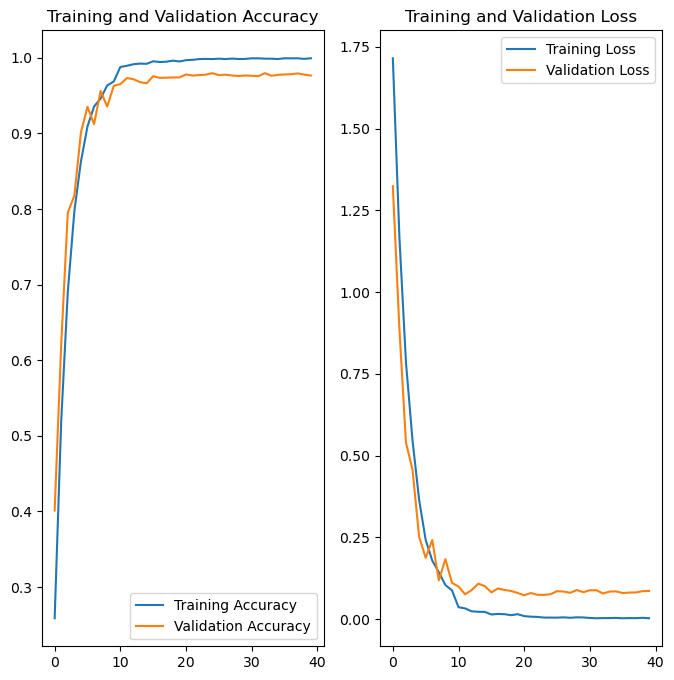

In [192]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [193]:
printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

442/442 [==============================] - 10s 21ms/step
Confusion Matrix
[[595   1   1   0   1   1]
 [  0 559  14   0  14   1]
 [  1   3 582   1   0   0]
 [  0   3   1 590   0   1]
 [  0  25   0   0 567   0]
 [  0   1   1   2   0 565]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      0.99      1.00       599
           Aedes vexans       0.94      0.95      0.95       588
     Anopheles sinensis       0.97      0.99      0.98       587
          Culex pipiens       0.99      0.99      0.99       595
Culex tritaeniorhynchus       0.97      0.96      0.97       592
            Non vectors       0.99      0.99      0.99       569

               accuracy                           0.98      3530
              macro avg       0.98      0.98      0.98      3530
           weighted avg       0.98      0.98      0.98      3530

Model is saved in ./models/Model_Early_Combine_Park_2022-09-19_09-44.h5


In [194]:
model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_31"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_625 (Conv2D)            (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                          

                                                                                                  
 max_pooling2d_220 (MaxPooling2  (None, 14, 14, 512)  0          ['conv2d_641[0][0]']             
 D)                                                                                               
                                                                                                  
 spatial_dropout2d_210 (Spatial  (None, 14, 14, 512)  0          ['max_pooling2d_220[0][0]']      
 Dropout2D)                                                                                       
                                                                                                  
 conv2d_642 (Conv2D)            (None, 14, 14, 512)  2359808     ['spatial_dropout2d_210[0][0]']  
                                                                                                  
 conv2d_643 (Conv2D)            (None, 14, 14, 512)  2359808     ['conv2d_642[0][0]']             
          

1793/1793 [==============================] - 150s 84ms/step - loss: 0.0478 - accuracy: 0.9833 - val_loss: 0.0880 - val_accuracy: 0.9742 - lr: 1.0000e-05

Epoch 21: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 21/40
1793/1793 [==============================] - 149s 83ms/step - loss: 0.0271 - accuracy: 0.9912 - val_loss: 0.0794 - val_accuracy: 0.9751 - lr: 5.0000e-06

Epoch 22: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 22/40
1793/1793 [==============================] - 150s 84ms/step - loss: 0.0230 - accuracy: 0.9926 - val_loss: 0.0718 - val_accuracy: 0.9782 - lr: 5.0000e-06

Epoch 23: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 23/40
1793/1793 [==============================] - 147s 82ms/step - loss: 0.0178 - accuracy: 0.9945 - val_loss: 0.0852 - val_accuracy: 0.9742 - lr: 5.0000e-06

Epoch 24: LearningRateScheduler setting learning rate to 4.999999873689376e-06.
Epoch 24/40
1793/1793 [=====

Maximum test accuracy is at 98.07 %.


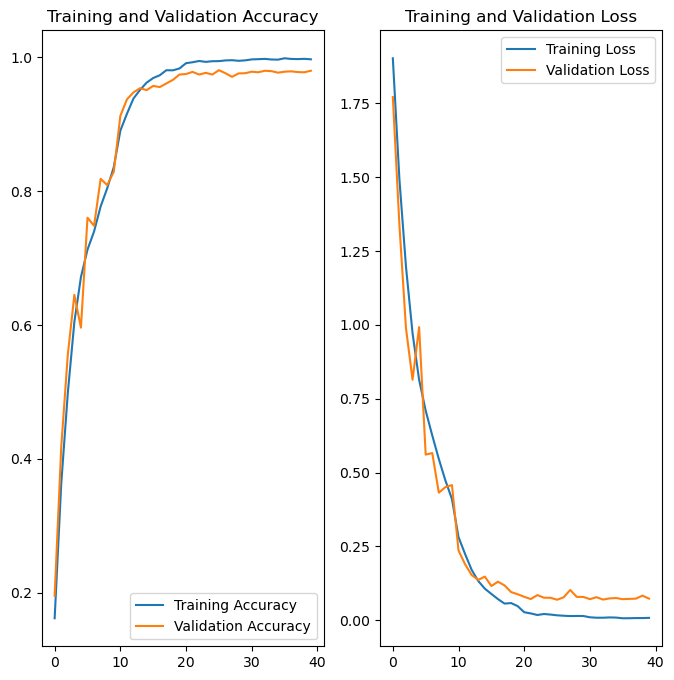

In [195]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [196]:
printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

442/442 [==============================] - 11s 24ms/step
Confusion Matrix
[[597   1   1   0   0   0]
 [  1 562   1   0  21   3]
 [  0  10 572   1   4   0]
 [  0   1   0 594   0   0]
 [  0  21   0   0 571   0]
 [  0   1   2   3   0 563]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      1.00      1.00       599
           Aedes vexans       0.94      0.96      0.95       588
     Anopheles sinensis       0.99      0.97      0.98       587
          Culex pipiens       0.99      1.00      1.00       595
Culex tritaeniorhynchus       0.96      0.96      0.96       592
            Non vectors       0.99      0.99      0.99       569

               accuracy                           0.98      3530
              macro avg       0.98      0.98      0.98      3530
           weighted avg       0.98      0.98      0.98      3530

Model is saved in ./models/Model_Middle_Combine_Park_2022-09-19_11-24.h5


In [197]:
model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

Model: "model_32"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 img0 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 img1 (InputLayer)              [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_645 (Conv2D)            (None, 224, 224, 64  1792        ['img0[0][0]']                   
                                )                                                          

 conv2d_665 (Conv2D)            (None, 28, 28, 512)  1180160     ['spatial_dropout2d_218[0][0]']  
                                                                                                  
 conv2d_653 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_652[0][0]']             
                                                                                                  
 conv2d_666 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_665[0][0]']             
                                                                                                  
 conv2d_654 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_653[0][0]']             
                                                                                                  
 conv2d_667 (Conv2D)            (None, 28, 28, 512)  2359808     ['conv2d_666[0][0]']             
                                                                                                  
 max_pooli

Epoch 12/40
1793/1793 [==============================] - 170s 95ms/step - loss: 0.0041 - accuracy: 0.9989 - val_loss: 0.0772 - val_accuracy: 0.9799 - lr: 1.0000e-05

Epoch 13: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 13/40
1793/1793 [==============================] - 171s 95ms/step - loss: 0.0039 - accuracy: 0.9987 - val_loss: 0.0492 - val_accuracy: 0.9847 - lr: 1.0000e-05

Epoch 14: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 14/40
1793/1793 [==============================] - 172s 96ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0562 - val_accuracy: 0.9841 - lr: 1.0000e-05

Epoch 15: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 15/40
1793/1793 [==============================] - 171s 95ms/step - loss: 0.0024 - accuracy: 0.9994 - val_loss: 0.0510 - val_accuracy: 0.9864 - lr: 1.0000e-05

Epoch 16: LearningRateScheduler setting learning rate to 9.999999747378752e-06.
Epoch 16/40
1793

Maximum test accuracy is at 98.84 %.


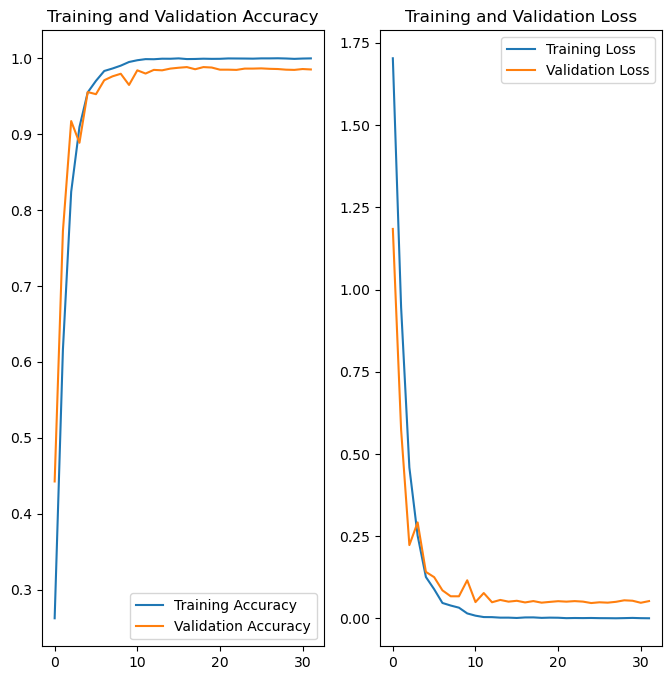

In [198]:
maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

In [199]:
printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

442/442 [==============================] - 12s 26ms/step
Confusion Matrix
[[598   0   0   0   0   1]
 [  0 567   4   0  12   5]
 [  0   0 587   0   0   0]
 [  0   0   0 594   0   1]
 [  0   6   0   0 586   0]
 [  1   6   2   3   0 557]]


Classification Report
                         precision    recall  f1-score   support

       Aedes albopictus       1.00      1.00      1.00       599
           Aedes vexans       0.98      0.96      0.97       588
     Anopheles sinensis       0.99      1.00      0.99       587
          Culex pipiens       0.99      1.00      1.00       595
Culex tritaeniorhynchus       0.98      0.99      0.98       592
            Non vectors       0.99      0.98      0.98       569

               accuracy                           0.99      3530
              macro avg       0.99      0.99      0.99      3530
           weighted avg       0.99      0.99      0.99      3530

Model is saved in ./models/Model_Late_Combine_Park_2022-09-19_12-56.h5


In [200]:
(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

Found 9558 files belonging to 6 classes.
Found 2352 files belonging to 6 classes.
Found 9558 files belonging to 6 classes.
Found 2352 files belonging to 6 classes.
Found 9558 files belonging to 6 classes.
Found 2352 files belonging to 6 classes.


In [201]:
model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

294/294 [==============================] - 8s 27ms/step


In [202]:
ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------

Epoch 1/20
598/598 [==============================] - 3s 4ms/step - loss: 0.4083 - accuracy: 0.8712
Epoch 2/20
598/598 [==============================] - 3s 4ms/step - loss: 0.0099 - accuracy: 0.9997
Epoch 3/20
598/598 [==============================] - 3s 4ms/step - loss: 0.0033 - accuracy: 0.9998
Epoch 4/20
598/598 [==============================] - 3s 4ms/step - loss: 0.0015 - accuracy: 0.9999
Epoch 5/20
598/598 [==============================] - 3s 4ms/step - loss: 8.3277e-04 - accuracy: 0.9999
Epoch 6/20
598/598 [==============================] - 3s 4ms/step - loss: 5.0355e-04 - accuracy: 1.0000
Epoch 7/20
598/598 [==============================] - 3s 4ms/step - loss: 3.6905e-04 - accuracy: 1.0000
Epoch 8/20
598/598 [==============================] - 2s 3ms/step - loss: 2.4587e-04 - accuracy: 1.0000
Epoch 9/20
598/598 [==============================] - 2s 3ms/step - loss: 1.8289e-04 - accuracy: 1.0000
Epoch 10/20
598/598 [==============================] - 2s 3ms/step - loss: 1.311

74/74 [==============================] - 0s 1ms/step


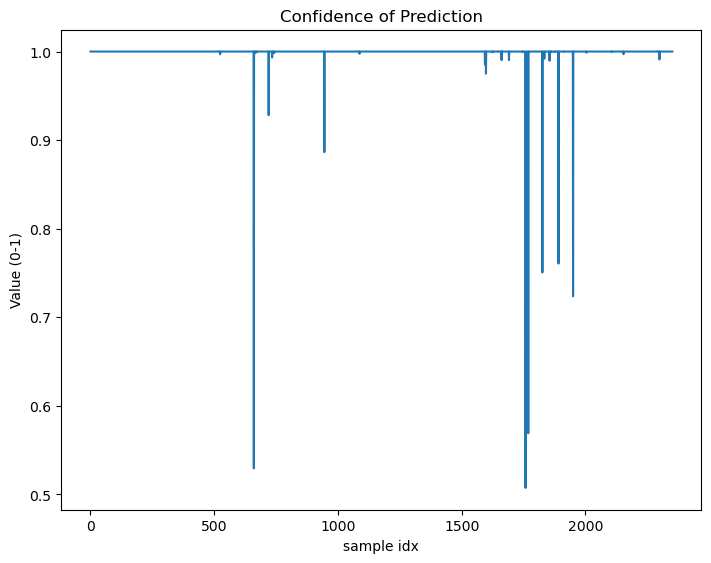

In [203]:
ensemble.evaluate(Yh_val,Y_val)
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)

In [ ]:
#---------------MODEL 11-----------------------------------------#

split_LR = tempfile.TemporaryDirectory().name
split_LMR = tempfile.TemporaryDirectory().name
randomSplitMosData(input_dir = mos_img_dir, output_dirLR = split_LR, output_dirLMR = split_LMR)
#----

(train_ds, val_ds, train_ds1, val_ds1) = read_ds(split_LR)
(train_ds_X_X1_Y, val_ds_X_X1_Y) = combineDS(train_ds, val_ds, train_ds1, val_ds1)

#----
model = buildEarlyModel()
model = loadVGG16ImageNetWeightsEarly(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

printConfusionMatrix(model, val_ds_X_X1_Y)
earlyModelPath = saveEarlyModel(model)
#-----

model = buildMiddleModel()
model = loadVGG16ImageNetWeightsMiddle(model)
model.summary()
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

printConfusionMatrix(model, val_ds_X_X1_Y)
middleModelPath = saveMiddleModel(model)
#-----

model = buildLateModel()
model.summary()
model = loadVGG16ImageNetWeightsLate(model)
model = compileModel(model)
fitHistory = fitModel(model, train_ds_X_X1_Y, val_ds_X_X1_Y, lr_adjust, early_stopping)
#----

maxAcc = np.max(fitHistory.history['val_accuracy'])
print('Maximum test accuracy is at', np.round(maxAcc*100,2), '%.')
plotAccuracyLoss(fitHistory)
#----

printConfusionMatrix(model, val_ds_X_X1_Y)
lateModelPath = saveLateModel(model)
#-----

(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR) = read_dsLMR(split_LMR)
(train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y,
            ) = combineDS_LMR(train_dsL, val_dsL, train_dsM, val_dsM, train_dsR, val_dsR)
#---------------------

model = keras.models.load_model(earlyModelPath)
(Yh_trainE, Yh_valE) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(middleModelPath)
(Yh_trainM, Yh_valM) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

model = keras.models.load_model(lateModelPath)
(Yh_trainL, Yh_valL) = predictLMR(model, train_ds_XL_XM_Y, val_ds_XL_XM_Y,
            train_ds_XM_XL_Y, val_ds_XM_XL_Y,
            train_ds_XM_XR_Y, val_ds_XM_XR_Y,
            train_ds_XR_XM_Y, val_ds_XR_XM_Y,
            train_ds_XL_XR_Y, val_ds_XL_XR_Y,
            train_ds_XR_XL_Y, val_ds_XR_XL_Y)

Yh_train = np.hstack((Yh_trainE, Yh_trainM))
Yh_train = np.hstack((Yh_train, Yh_trainL))
Yh_val = np.hstack((Yh_valE, Yh_valM))
Yh_val = np.hstack((Yh_val, Yh_valL))
Y_train = np.concatenate([y for (x,y) in train_ds_XL_XM_Y], axis=0)
Y_val = np.concatenate([y for (x,y) in val_ds_XL_XM_Y], axis=0)
#----------------------------------

ensemble = trainEnsemble(Yh_train, Y_train)

#----------------------------------
ensemble.evaluate(Yh_val,Y_val)
confidence = np.max(ensemble.predict(Yh_val),axis=1)
plotConfidence(confidence)